# IMPORT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, tqdm
import seaborn as sns
import scipy.io
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import shutil
import matplotlib.pyplot as plt

# About Data

### Li-ion Battery Aging Datasets

This data set has been collected from a custom built battery prognostics testbed at the NASA Ames Prognostics Center of Excellence (PCoE). Li-ion batteries were run through 3 different operational profiles (charge, discharge and Electrochemical Impedance Spectroscopy) at different temperatures. Discharges were carried out at different current load levels until the battery voltage fell to preset voltage thresholds. Some of these thresholds were lower than that recommended by the OEM (2.7 V) in order to induce deep discharge aging effects. Repeated charge and discharge cycles result in accelerated aging of the batteries. The experiments were stopped when the batteries reached the end-of-life (EOL) criteria of 30% fade in rated capacity (from 2 Ah to 1.4 Ah).



**Data Acquisition:**

The testbed comprises:

* Commercially available Li-ion 18650 sized rechargeable batteries,
* Programmable 4-channel DC electronic load,
* Programmable 4-channel DC power supply,
* Voltmeter, ammeter and thermocouple sensor suite,
* Custom EIS equipment,
* Environmental chamber to impose various operational conditions,
* PXI chassis based DAQ and experiment control, and



MATLAB based experiment control, data acquisition and prognostics algorithm evaluation setup (appx. data acquisition rate is 10Hz).



**Parameter Description:**

Data Structure:

- cycle: top level structure array containing the charge, discharge and impedance operations

- type: operation type, can be charge, discharge or impedance

- ambient_temperature: ambient temperature (degree C)

- time: the date and time of the start of the cycle, in MATLAB date vector format

- data: data structure containing the measurements


for Charge the fields are:

- Voltage_measured: Battery terminal voltage (Volts)

- Current_measured: Battery output current (Amps)

- Temperature_measured: Battery temperature (degree C)

- Current_charge: Current measured at charger (Amps)

- Voltage_charge: Voltage measured at charger (Volts)

- Time: Time vector for the cycle (secs)


for Discharge the fields are:

- Voltage_measured: Battery terminal voltage (Volts)

- Current_measured: Battery output current (Amps)

- Temperature_measured: Battery temperature (degree C)

- Current_charge: Current measured at load (Amps)

- Voltage_charge: Voltage measured at load (Volts)

- Time: Time vector for the cycle (secs)

- Capacity: Battery capacity (Ahr) for discharge till 2.7V



for Impedance the fields are:

- Sense_current: Current in sense branch (Amps)

- Battery_current: Current in battery branch (Amps)

- Current_ratio: Ratio of the above currents

- Battery_impedance: Battery impedance (Ohms) computed from raw data

- Rectified_impedance: Calibrated and smoothed battery impedance (Ohms)

- Re: Estimated electrolyte resistance (Ohms)

- Rct: Estimated charge transfer resistance (Ohms)

# Transforming MATLAB files into Machine Learning Reading CSV files

This project uses the Li-ion battery dataset by NASA. The objective of this section is to explore the original raw dataset and transform it into a Machine Learning ready dataset in a significantly better format.

In [ ]:
# Helper functions
def load_filelist():
    
    FILELIST = []
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:

            #filepath = filename
            FILELIST.append(os.path.join(dirname, filename))
    return FILELIST
            
            
def filter_matfiles_list(filelist):
    filelist = [filepath for filepath in filelist if filepath.endswith('.mat')]
    filelist = [filepath for filepath in filelist if "BatteryAgingARC_25_26_27_28_P1" not in filepath] # removing duplicates
    return filelist


def loadmat(filepath):
    return scipy.io.loadmat(filepath, simplify_cells=True)

In [ ]:
FILELIST = filter_matfiles_list(load_filelist())

## Generic Dataset Informations
Repeated charge and discharge cycles result in accelerated aging of the batteries while impedance measurements provide insight into the internal battery parameters that change as aging progresses.

- Charge profile:
    - The charge profile for all battery tests seems to be identifical.
    - Charging was carried out in a constant current (CC) mode at 1.5A until the battery voltage reached 4.2V and then continued in a constant voltage (CV) mode until the charge current dropped to 20mA. 

- Discharge:
    - Discharge profiles were different from battery to battery.
    - Discharge was carried out at a constant current (CC) level of 1-4 A until the battery voltage fell to values such 2.7V, 2.5V, 2.2V and 2.5V.

- Impedance:
    - Impedance measurement was carried out through an electrochemical impedance spectroscopy (EIS) frequency sweep from 0.1Hz to 5kHz.

The experiments were stopped when the batteries reached a given end-of-life (EOL) criteria: for example 30% fade in rated capacity (from 2Ahr to 1.4Ahr). Other stopping criteria were used such as 20% fade in rated capacity. Note that for batteries 49,50,51,52, the experiments were not stop due to battery EOL but because the software has crashed.

## Tasks

This dataset can be used for the prediction of both:
- remaining charge (for a given discharge cycle) and,
- remaining useful life (RUL).

## Structure of .mat files
- **dictionary** (loaded mat file)
    - **dictionary** (e.g. B0005)
        - **list (cycle)** -> one test per element in the list
            - element of the list = dict = all data for one test of that battery
                - **type**:  operation  type, can be charge, discharge or impedance
                - **ambient_temperature**:  ambient temperature (degree C)
                - **time**:  the date and time of the start of the cycle, in MATLAB  date vector format
                - **data (dict)**:  data structure containing the measurements
                    - data fields with key being measured variable, values the actual records (see below)
                    
                    
*    for charge the fields are:
    *     Voltage_measured: 	Battery terminal voltage (Volts)
    *     Current_measured:	Battery output current (Amps)
    *     Temperature_measured: 	Battery temperature (degree C)
    *     Current_charge:		Current measured at charger (Amps)
    *     Voltage_charge:		Voltage measured at charger (Volts)
    *     Time:			Time vector for the cycle (secs)
*    for discharge the fields are:
    *     Voltage_measured: 	Battery terminal voltage (Volts)
    *     Current_measured:	Battery output current (Amps)
    *     Temperature_measured: 	Battery temperature (degree C)
    *     Current_load:		Current measured at load (Amps)
    *     Voltage_load:		Voltage measured at load (Volts)
    *     Time:			Time vector for the cycle (secs)
    *     Capacity:		Battery capacity (Ahr) for discharge till 2.7V 
*    for impedance the fields are:
    *     Sense_current:		Current in sense branch (Amps)
    *     Battery_current:	Current in battery branch (Amps)
    *     Current_ratio:		Ratio of the above currents 
    *     Battery_impedance:	Battery impedance (Ohms) computed from raw data
    *     Rectified_impedance:	Calibrated and smoothed battery impedance (Ohms) 
    *     Re:			Estimated electrolyte resistance (Ohms)
    *     Rct:			Estimated charge transfer resistance (Ohms)

In [ ]:
mat = loadmat("../input/d/zlayuz/nasa-battery-dataset/NASA-BATTERY-DATASET/BatteryAgingARC-FY08Q4/B0005.mat/B0005.mat")

In [ ]:
df = pd.DataFrame(data=mat['B0005']['cycle'][0]['data'])

In [ ]:
df.info()

In [ ]:
import matplotlib.pyplot as plt

def plot_test_data(df, profile="charge"):
    
    if profile=='charge':
        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Voltage_measured, 'b', label='Voltage_measured')
        plt.plot(df.Time, df.Current_measured, 'r', label='Current_measured')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Voltage_charge, 'b', label='Voltage_charge')
        plt.plot(df.Time, df.Current_charge, 'r', label='Current_charge')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Temperature_measured, 'k', label='Temperature_measured')
        plt.legend()
        plt.show()
    elif profile=='discharge':
        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Voltage_measured, 'b', label='Voltage_measured')
        plt.plot(df.Time, df.Current_measured, 'r', label='Current_measured')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Voltage_load, 'b', label='Voltage_load')
        plt.plot(df.Time, df.Current_load, 'r', label='Current_load')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Temperature_measured, 'k', label='Temperature_measured')
        plt.legend()
        plt.show()
    elif profile=='impedance':
        pass
    else:
        print('No cycle recognized')

In [ ]:
plot_test_data(df)

In [ ]:
df = pd.DataFrame(data=mat['B0005']['cycle'][1]['data'])
df.head()

In [ ]:
def process_data_dict(data_dict):
    """ Creates two dictionaries:
    - ndict: new dictionary with the test data to build a corresponding dataframe
    - metadata_dict: anything that doesn't fit in ndict ('Capacity' is just a float)
    """
    
    ndict = {}
    metadata_dict = {}
    for k, v in data_dict.items():
        if k not in ['Capacity', 'Re', 'Rct']:
            ndict[k]=v
        elif k == 'Capacity':
            metadata_dict[k]=v
        elif k == 'Re':
            metadata_dict[k]=v
        elif k == 'Rct':
            metadata_dict[k]=v
        else:
            print("Exception")
    
    return ndict, metadata_dict


def fill_metadata_row(metadata, test_type, test_start_time, test_temperature, battery_name, test_id, uid, filename, capacity, re, rct):
    tmp = pd.DataFrame(data=[test_type, test_start_time, test_temperature, battery_name, test_id, uid, filename, capacity, re, rct])
    tmp = tmp.transpose()
    tmp.columns = metadata.columns
    metadata = pd.concat((metadata, tmp), axis=0)
    return metadata


def extract_more_metadata(metadata_dict):
    
    if 'Capacity' in metadata_dict.keys():
        capacity = metadata_dict['Capacity']
    else:
        capacity = np.nan
        
    if 'Re' in metadata_dict.keys():
        re = metadata_dict['Re']
    else:
        re = np.nan
        
    if 'Rct' in metadata_dict.keys():
        rct = metadata_dict['Rct']
    else:
        rct = np.nan
    
    return capacity, re, rct

The metadata.csv file is used to store information about various files, indicating whether they represent charging, discharging, or impedance data. For example, file 0001.csv contains charging data for battery number 25.

In [ ]:
metadata = pd.DataFrame(data=None, columns=['type', 'start_time', 'ambient_temperature', 'battery_id', 'test_id', 'uid', 'filename', 'Capacity', 'Re', 'Rct'])
battery_list = [item.split('/')[-1].split('.')[0] for item in FILELIST]

In [ ]:
# We create a tmp directory in which we will save all CSV files
CWD = os.getcwd()
os.listdir(CWD)
directory = "tmp"
path = os.path.join(CWD, directory)
if not os.path.exists(path):
    os.mkdir(path)

In [ ]:
os.listdir(CWD) # we check that tmp exists now

## Converting to CSV

In [ ]:
uid = 0
# counter = 0
for battery_name, mat_filepath in zip(battery_list, FILELIST):
    # counter +=1
    
    mat_data = scipy.io.loadmat(mat_filepath, simplify_cells=True)
    print(mat_filepath[-10:],"-->", battery_name)
    test_list = mat_data[battery_name]['cycle']
    
    for test_id in range(len(test_list)):
        
        uid += 1
        filename = str(uid).zfill(5)+'.csv'
        # filepath = './tmp/' + filename

        # Extract the specific test data and save it as CSV! 
        ndict, metadata_dict = process_data_dict(test_list[test_id]['data'])
        # test_df = pd.DataFrame.from_dict(ndict, orient='index')
        # test_df = test_df.transpose()

        # test_df.to_csv(filepath, index=False)
                
        # Add test information to the metadata
        test_type = test_list[test_id]['type']
        test_start_time = test_list[test_id]['time']
        test_temperature = test_list[test_id]['ambient_temperature']
        
        capacity, re, rct = extract_more_metadata(metadata_dict)
        metadata = fill_metadata_row(metadata, test_type, test_start_time, test_temperature, battery_name, test_id, uid, filename, capacity, re, rct)
        
    # if counter > 2:
    #    break

In [ ]:
metadata.to_csv('metadata.csv', index=False)

In [ ]:
metadata.info()

# Preparing DATA for Analysis 

## START TIME FORMATTNG 

### Convert start_time column into datetime format

In [ ]:
# Reset the index of metadata dataframe
metadata = metadata.reset_index(drop=True)
metadata 
# Note that the start_time column is not in datetime format
# It becomes worse when the dataframe is exported into csv and then imported with read_csv
# Such that the start_time column is not only in incorrect format but also having in inconsistent formats
# Inconsistent formats after importing: 
# string of list of floats '[2010.       7.      21.      15.       0.      35.093]' 
# string of list of ints '[2010    7   21   20   31    5]'
# string of list of floats in scientific form '[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2.0000e+00 5.6984e+01]', etc.

In [ ]:
from datetime import datetime

# Function to convert list to datetime
def convert_list_to_datetime(lst):
    y = int(lst[0])
    m = int(lst[1])
    d = int(lst[2])
    H = int(lst[3])
    M = int(lst[4])
    S = int(lst[5])  # Seconds rounded to integer
    return datetime(y, m, d, H, M, S)

# Apply function to entire column
metadata_1 = metadata.copy()
metadata_1['start_time'] = metadata_1['start_time'].apply(convert_list_to_datetime)

# Test
print(metadata_1['start_time'][0])  # Should print datetime object
print(metadata_1['start_time'][0].year)  # Should correctly give year

In [ ]:
# Example usage of start_time column
metadata_1['start_time'][0].year # year, month, day, hour, minute, second

In [ ]:
metadata_1.to_csv('metadata.csv', index=False)

In [ ]:
metadata_1.info()

# EDA

In [7]:
# We will use the matadata csv with corrected start_time format
metadata_df = pd.read_csv("/kaggle/input/nasa-dataset-start-time-formatting/metadata.csv")
# metadata_df['start_time'] = pd.to_datetime(metadata_df['start_time'])
# metadata_df=metadata_1
# metadata_df

In [ ]:
# Replace [] with np.nan in Capacity column
metadata_df.loc[metadata_df["Capacity"]=="[]", "Capacity"] = np.nan
metadata_df[metadata_df["Capacity"]=="[]"]["Capacity"]

In [2]:
battery_group = {"1": ["B0025", "B0026", "B0027", "B0028"],
                "2b": ["B0029", "B0030", "B0031", "B0032"],
                "2c": ["B0033", "B0034", "B0036"],
                "2d": ["B0038", "B0039", "B0040"],
                "2e": ["B0041", "B0042", "B0043", "B0044"],
                "3": ["B0045", "B0046", "B0047", "B0048"],
                "4": ["B0049", "B0050", "B0051", "B0052"],
                "5": ["B0053", "B0054", "B0055", "B0056"],
                "6": ["B0005", "B0006", "B0007", "B0018"]}

In [10]:
# Create box plots for each battery in each group
def plot_capacity_boxplot(cells: dict, group: str):
    plt.rcParams.update(plt.rcParamsDefault)
    fig, ax = plt.subplots()
    capacity = []
    for cell in cells[group]:
        df = metadata_df[(metadata_df["battery_id"]==cell) & (metadata_df["type"]=="discharge")].copy()
        clist = df[df["Capacity"].notna()]["Capacity"].astype(float).tolist()
        capacity.append(clist)
        # print(len(clist))
        
    ax.boxplot(capacity)
    plt.legend()
    plt.ylim(-0.4,2.9)
    plt.xticks(range(1,len(cells[group]) + 1), cells[group])
    #plt.xlabel("Battery")
    plt.ylabel("Capacity [Ah]")
    plt.rcParams['axes.titley'] = 1.0 # title inside
    plt.rcParams['axes.titlepad'] = -14  # pad is in points...
    plt.title(f"Group {group}")
    plt.show()

In [4]:
def plot_capacity_vs_cycle(cells: dict, group: str):
    plt.rcParams.update(plt.rcParamsDefault)
    fig, ax = plt.subplots()
    for cell in cells[group]:
        df = metadata_df[(metadata_df["battery_id"]==cell) & (metadata_df["type"]=="discharge")].copy()
        df["Capacity"] = df["Capacity"].astype(float)
        df["cycle"] = range(len(df))
        ax.plot(df["cycle"], df["Capacity"], marker='.', label=cell)
        
    plt.axhline(70.0, color='k', linestyle='--')    
    plt.legend()
    plt.ylim(0,2.49)
    #plt.xlim(0,30)
    plt.xlim(0,199)
    plt.xlabel("Cycle number")
    plt.ylabel("Capacity [Ah]")
    plt.rcParams['axes.titley'] = 1.0 # title inside
    plt.rcParams['axes.titlepad'] = -14  # pad is in points...
    plt.title(f"Group {group}")
    plt.show()

In [5]:
def plot_SOH_vs_cycle(cells: dict, group: str):
    plt.rcParams.update(plt.rcParamsDefault)
    fig, ax = plt.subplots()
    for cell in cells[group]:
        df = metadata_df[(metadata_df["battery_id"]==cell) & (metadata_df["type"]=="discharge")].copy()
        df["Capacity"] = df["Capacity"].astype(float)/2.0 * 100.0
        df["cycle"] = range(len(df))
        ax.plot(df["cycle"], df["Capacity"], marker='.', label=cell)
        
    plt.axhline(70.0, color='k', linestyle='--')    
    plt.legend()
    plt.ylim(0,119)
    plt.xlim(0,199)
    plt.xlabel("Cycle number")
    plt.ylabel("SOH %")
    plt.rcParams['axes.titley'] = 1.0 # title inside
    plt.rcParams['axes.titlepad'] = -14  # pad is in points...
    plt.title(f"Group {group}")
    plt.show()

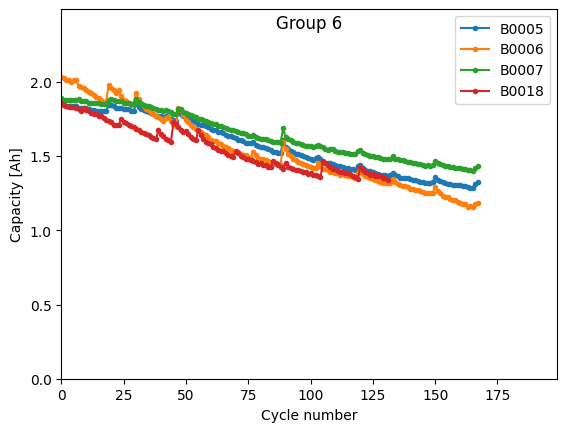

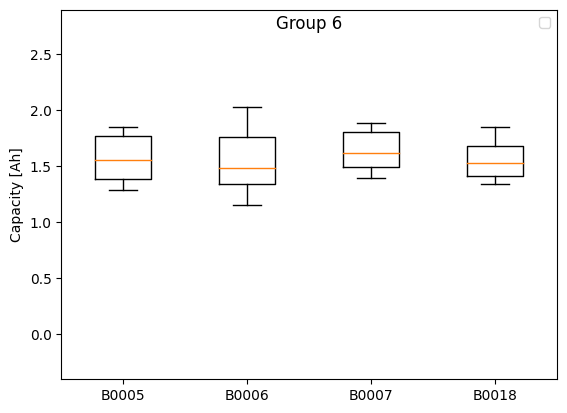

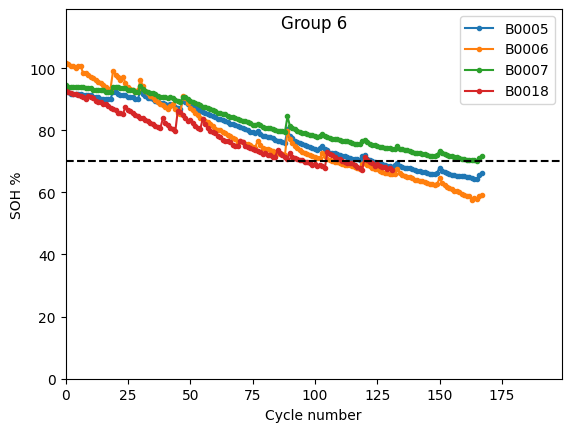

In [11]:
GROUP = "6"
plot_capacity_vs_cycle(battery_group, GROUP)
plot_capacity_boxplot(battery_group, GROUP)
plot_SOH_vs_cycle(battery_group, GROUP)

In [14]:
# Label each battery with their group
metadata_df["Group"] = ""
for key in list(battery_group.keys()):
    for cell in battery_group[key]:
        metadata_df.loc[metadata_df["battery_id"]==cell, "Group"] = key
    
metadata_df

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct,Group
0,discharge,2010-07-21 15:00:35,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN,3
1,impedance,2010-07-21 16:53:45,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333,3
2,charge,2010-07-21 17:25:40,4,B0047,2,3,00003.csv,NaN,NaN,NaN,3
3,impedance,2010-07-21 20:31:05,24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734,3
4,discharge,2010-07-21 21:02:56,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...
7560,impedance,2010-09-30 07:36:45,24,B0055,247,7561,07561.csv,NaN,0.0968087979207628,0.15489738203707232,5
7561,discharge,2010-09-30 08:08:36,4,B0055,248,7562,07562.csv,1.0201379996149256,NaN,NaN,5
7562,charge,2010-09-30 08:48:54,4,B0055,249,7563,07563.csv,NaN,NaN,NaN,5
7563,discharge,2010-09-30 11:50:17,4,B0055,250,7564,07564.csv,0.9907591663373165,NaN,NaN,5


In [15]:
#battery_ids = metadata_df["battery_id"].value_counts().index
# Manually arranged
battery_ids = ['B0007', 'B0005', 'B0006', 'B0018', 'B0033', 'B0036', 'B0034', 'B0044',
               'B0043', 'B0042', 'B0041', 'B0054', 'B0056', 'B0055', 'B0053', 'B0047', 
               'B0048', 'B0045', 'B0046', 'B0040', 'B0039', 'B0038', 'B0030', 'B0029',
               'B0031', 'B0032', 'B0026', 'B0025', 'B0028', 'B0027', 'B0049', 'B0052',
               'B0051', 'B0050']

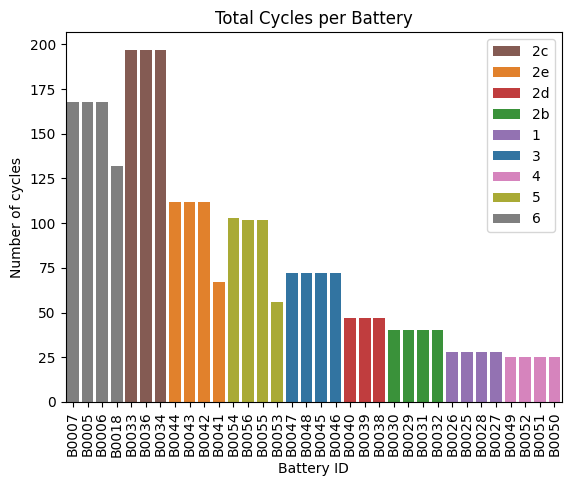

In [16]:
plt.rcParams.update(plt.rcParamsDefault)
sns.countplot(data=metadata_df[metadata_df["type"]=="discharge"], x="battery_id", order=battery_ids, dodge=False, hue=metadata_df["Group"])
plt.tick_params(axis='x', rotation=90)
plt.ylabel("Number of cycles")
plt.xlabel("Battery ID")

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [5,1,3,2,4,0,6,8,7] # Quite confusing

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper right") 

plt.title('Total Cycles per Battery')
plt.show()

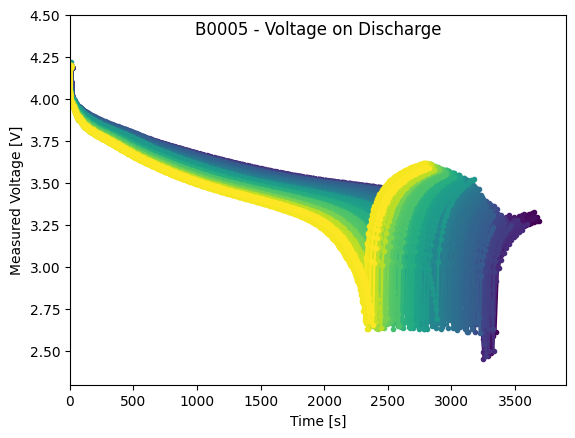

In [17]:
# Plot voltage vs time during discharging cycles
BATTERY_ID = "B0005"
filenames = metadata_df[(metadata_df["battery_id"]==BATTERY_ID) & (metadata_df["type"]=="discharge")]['filename'].tolist()

cycle = 1
N = len(filenames)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))
fig, ax = plt.subplots()
for filename in filenames:
    battery_data = pd.read_csv(f"/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/{filename}")
    # Add start_time and Time (seconds)
    #start_time = metadata_df[metadata_df["filename"]==filename]['start_time']
    #battery_data['Date'] = start_time.iloc[0] + pd.to_timedelta(battery_data['Time'], unit='s')   
    ax.plot(battery_data["Time"], battery_data["Voltage_measured"], marker='.', label=cycle)
    cycle += 1
    
plt.ylim(2.3,4.5)
plt.xlim(0,3900)
plt.xlabel("Time [s]")
plt.ylabel("Measured Voltage [V]")
plt.rcParams['axes.titley'] = 1.0 # title inside
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
plt.title(f"{BATTERY_ID} - Voltage on Discharge")
plt.show()

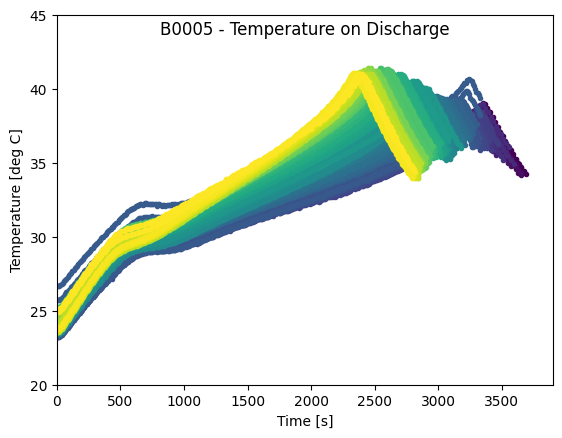

In [18]:
# Plot temperature vs time during discharging cycles
filenames = metadata_df[(metadata_df["battery_id"]==BATTERY_ID) & (metadata_df["type"]=="discharge")]['filename'].tolist()

fig, ax = plt.subplots()
cycle = 1
for filename in filenames:
    battery_data = pd.read_csv(f"/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/{filename}")
    ax.plot(battery_data["Time"], battery_data["Temperature_measured"], marker='.', label=cycle)
    cycle += 1
       
plt.ylim(20, 45) 
plt.xlim(0,3900)
plt.xlabel("Time [s]")
plt.ylabel("Temperature [deg C]")
plt.rcParams['axes.titley'] = 1.0 # title inside
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
plt.title(f"{BATTERY_ID} - Temperature on Discharge")
plt.show()

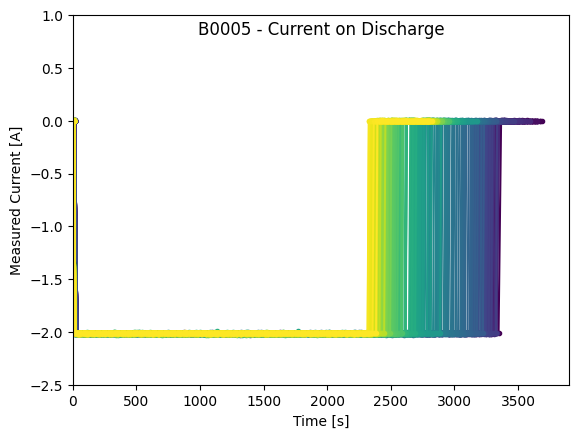

In [19]:

# Plot current vs time during discharging cycles
filenames = metadata_df[(metadata_df["battery_id"]==BATTERY_ID) & (metadata_df["type"]=="discharge")]['filename'].tolist()

cycle = 1
N = len(filenames)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))
fig, ax = plt.subplots()
for filename in filenames:
    battery_data = pd.read_csv(f"/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/{filename}")
    ax.plot(battery_data["Time"], battery_data["Current_measured"], marker='.', label=cycle)
    cycle += 1
    
plt.ylim(-2.5,1) 
plt.xlim(0,3900)
plt.xlabel("Time [s]")
plt.ylabel("Measured Current [A]")
plt.rcParams['axes.titley'] = 1.0 # title inside
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
plt.title(f"{BATTERY_ID} - Current on Discharge")
plt.show()

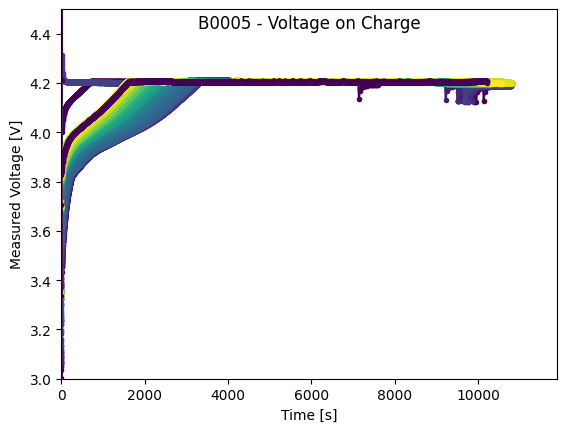

In [20]:
# Plot voltage vs time during charging cycles 
filenames = metadata_df[(metadata_df["battery_id"]==BATTERY_ID) & (metadata_df["type"]=="charge")]['filename'].tolist()

fig, ax = plt.subplots()
cycle = 1
for filename in filenames:
    battery_data = pd.read_csv(f"/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/{filename}") 
    ax.plot(battery_data["Time"], battery_data["Voltage_measured"], marker='.', label=cycle)
    cycle += 1
    
plt.ylim(3,4.5)    
plt.xlim(0,11900)
plt.xlabel("Time [s]")
plt.ylabel("Measured Voltage [V]")
plt.rcParams['axes.titley'] = 1.0 # title inside
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
plt.title(f"{BATTERY_ID} - Voltage on Charge")
plt.show()

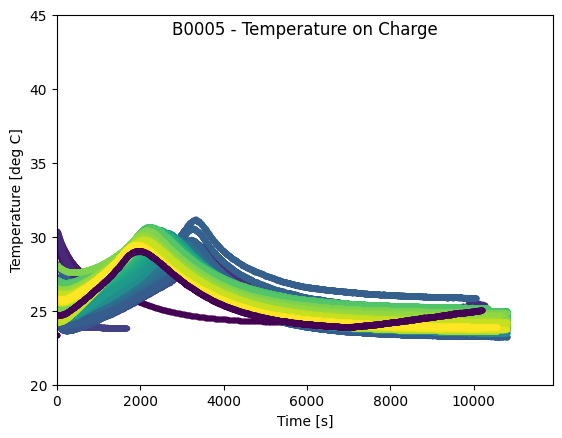

In [21]:
# Plot temperature vs time during Charging cycles
filenames = metadata_df[(metadata_df["battery_id"]==BATTERY_ID) & (metadata_df["type"]=="charge")]['filename'].tolist()

fig, ax = plt.subplots()
cycle = 1
for filename in filenames:
    battery_data = pd.read_csv(f"/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/{filename}")
    ax.plot(battery_data["Time"], battery_data["Temperature_measured"], marker='.', label=cycle)
    cycle += 1
       
plt.ylim(20, 45)        
plt.xlim(0,11900)
plt.xlabel("Time [s]")
plt.ylabel("Temperature [deg C]")
plt.rcParams['axes.titley'] = 1.0 # title inside
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
plt.title(f"{BATTERY_ID} - Temperature on Charge")
plt.show()

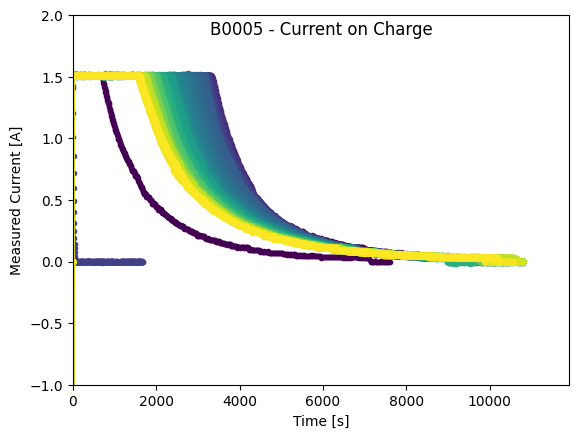

In [22]:
# Plot Current vs time during charging cycles
filenames = metadata_df[(metadata_df["battery_id"]==BATTERY_ID) & (metadata_df["type"]=="charge")]['filename'].tolist()

cycle = 1
N = len(filenames)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))
fig, ax = plt.subplots()
for filename in filenames:
    battery_data = pd.read_csv(f"/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/{filename}")  
    ax.plot(battery_data["Time"], battery_data["Current_measured"], marker='.', label=cycle)
    cycle += 1
    
plt.ylim(-1,2)    
plt.xlim(0,11900)
plt.xlabel("Time [s]")
plt.ylabel("Measured Current [A]")
plt.rcParams['axes.titley'] = 1.0 # title inside
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
plt.title(f"{BATTERY_ID} - Current on Charge")
plt.show()

# Preparing Data for Model Training

In [2]:
main_path=('../input/nasa-battery-dataset/cleaned_dataset')

In [ ]:
meta_pd=pd.read_csv(os.path.join(main_path,'metadata.csv'))

In [ ]:
meta_pd

In [ ]:
meta_pd['battery_id'].unique()

In [ ]:
#reference
data1_pd=pd.read_csv(os.path.join(main_path,'data','00003.csv'))
data2_pd=pd.read_csv(os.path.join(main_path,'data','00005.csv'))

In [ ]:
#charging
data1_pd.head()

In [ ]:
#discharging
data2_pd.head()

In [ ]:
meta_pd['Capacity'] = pd.to_numeric(meta_pd['Capacity'], errors='coerce')

For SoC prediction only Charging and Discharging Data of each battery is required

In [ ]:
filtered_df=meta_pd[meta_pd['type']!='impedance']
filtered_df=filtered_df.fillna(1e-6)

In [ ]:
#check if current is always negative in discharging Data
c=0
for idx,row in meta_pd[meta_pd['type']=='charge'].iterrows():
    file = pd.read_csv(os.path.join(main_path,'data',row['filename']))
    c=max(c,max(file['Current_measured']))
print(c)

Since, Current in Discharging Data is not always Negative. So a is_charging flag must be used to Differentitate between Charging and Dischargining Data.

Capacity is an Important parameter in determining SoC. However,the Charging data does not  contain Capacity information of each battery. Hence, for Charging the maximum capacity for each battery is considered while for Discharging the corresponding Capacity Data is considered.

In [ ]:
combined_df[combined_df['Capacity']==0]['battery_id'].unique()

In [ ]:
capacities_df=meta_pd[meta_pd['type']=='discharge'][['battery_id','Capacity']]

In [ ]:
capacities_df

In [ ]:
#for charging
cap={}
for bid in capacities_df['battery_id'].unique():
    battery_df = capacities_df[(capacities_df['battery_id'] == bid)]
    battery_df['Capacity'] = pd.to_numeric(battery_df['Capacity'], errors='coerce')
    if 'Capacity' in battery_df.columns:
        capacity = battery_df['Capacity'].dropna().max()
    else:
        capacity = 0.0
    cap[bid] = capacity

In [ ]:
dfs = []
for idx, row in filtered_df.iterrows():
    file_path = os.path.join(main_path,'data',row['filename'])
    df = pd.read_csv(file_path)
    df=df[['Voltage_measured','Current_measured','Temperature_measured','Time']]
    df['battery_id']=row['battery_id']
    df['is_charging']= (row['type']=='charge')*1
    if row['type']=='discharge':
        df['Capacity']=row['Capacity']
    else:
        df['Capacity']=cap[row['battery_id']]
    dfs.append(df)
combined_df = pd.concat(dfs, ignore_index=True)

print(combined_df.shape)

In [1]:
combined_df.head()

NameError: name 'combined_df' is not defined

In [ ]:
combined_df.isnull().sum()

In [ ]:
combined_df=combined_df.dropna()

In [ ]:
#save dataset
combined_df.to_csv('/kaggle/working/combined_df.csv',index=False)

In [3]:
# when session restarts
combined_df=pd.read_csv('/kaggle/input/combined-li-battery-dataset/combined_df.csv')

In [ ]:
def compute_soc(df, time_col='Time', current_col='Current_measured', 
                        flag_col='is_charging', battery_col='battery_id', initial_soc=0.5, cap_col='Capacity'):
    tmp = df.copy()

    # Sort correctly
    tmp = tmp.sort_values([battery_col, time_col]).reset_index(drop=True)

    # Calculate delta_t safely
    tmp['delta_t'] = tmp.groupby(battery_col)[time_col].diff()
    tmp['delta_t'] = tmp['delta_t'].apply(lambda x: x if pd.notna(x) and x > 0 else 1e-4)

    # delta_Ah
    tmp['delta_Ah'] = (tmp[current_col] * tmp['delta_t']) / 3600.0

    # Flip sign if charging
    tmp['delta_Ah_signed'] = tmp['delta_Ah'] * tmp[flag_col].apply(lambda x: -1 if x else 1)

    # Cumulative transferred Ah
    tmp['comb_Ah'] = tmp.groupby(battery_col)['delta_Ah_signed'].cumsum()

    # --- Fix battery capacities ---
    battery_capacity = tmp.groupby(battery_col)[cap_col].max()
    battery_capacity = battery_capacity[battery_capacity > 0].dropna()
    battery_capacity = battery_capacity.to_dict()

    tmp['battery_capacity'] = tmp[battery_col].map(battery_capacity)

    if tmp['battery_capacity'].isna().any():
        raise ValueError("Missing Battery Capacity.")

    # Compute SoC
    tmp['SoC'] = initial_soc + (tmp['comb_Ah'] / tmp['battery_capacity'])
    tmp['SoC'] = tmp['SoC'].clip(0, 1)

    return df.merge(tmp[[battery_col, time_col, 'Voltage_measured', 'SoC']], on=[battery_col, time_col,'Voltage_measured'], how='left')


In [5]:
def compute_delta_t(df, time_col='Time', group_cols=['battery_id', 'is_charging']):
    
    df = df.copy()
    df = df.sort_values(group_cols + [time_col]).reset_index(drop=True)
    
    df['delta_t'] = df.groupby(group_cols)[time_col].diff()
    
    # Handle any NaN or negative delta_t
    df['delta_t'] = df['delta_t'].apply(lambda x: x if pd.notna(x) and x > 0 else 0)
    
    return df


In [11]:
print(combined_df['SoC'].max())
print(combined_df['SoC'].min())
combined_df[combined_df['battery_id']=='B0047'].head(100)

0.5014694857936012
0.0


,Voltage_measured,Current_measured,Temperature_measured,Time,battery_id,is_charging,Capacity,SoC,delta_t
5803600,4.246711,0.000252,6.212696,0.000,B0047,0,1.674305,0.500000,0.000000e+00
5803601,4.186636,-0.001666,5.454957,0.000,B0047,0,1.524366,0.500000,0.000000e+00
5803602,4.199923,-0.003475,6.145254,0.000,B0047,0,1.508076,0.500000,0.000000e+00
5803603,4.199569,-0.000896,4.553269,0.000,B0047,0,1.483558,0.500000,0.000000e+00
5803604,4.199397,0.000422,4.826283,0.000,B0047,0,1.467139,0.500000,0.000000e+00
...,...,...,...,...,...,...,...,...,...
5803695,4.151678,-0.003783,3.995534,9.328,B0047,0,1.190790,0.497722,0.000000e+00
5803696,4.195291,-0.001027,5.520739,9.328,B0047,0,1.284916,0.497722,5.329071e-15
5803697,4.194305,-0.001488,5.861862,9.328,B0047,0,1.246649,0.497722,0.000000e+00
5803698,4.197420,-0.001882,4.822025,9.329,B0047,0,1.419275,0.497722,1.000000e-03


In [10]:
combined_df.info()

,Voltage_measured,Current_measured,Temperature_measured,Time,battery_id,is_charging,Capacity,SoC,delta_t
0,4.191492,-0.004902,24.330034,0.0,B0005,0,1.856487,0.5,0.0
1,4.189773,0.000021,24.697752,0.0,B0005,0,1.846327,0.5,0.0
2,4.188187,-0.001754,24.734266,0.0,B0005,0,1.835349,0.5,0.0
3,4.188461,-0.002775,24.654236,0.0,B0005,0,1.835263,0.5,0.0
4,4.188299,-0.007981,24.524797,0.0,B0005,0,1.834646,0.5,0.0


### Train Test Spliting

The data is split into Train, Validation and Test Sets based on the Battery ids. This is done so the models can learn from the charging and discharging patterns of the Train Set of Batteries and then be tested to predict the SoC of another unseen set of Batteries.

In [12]:
batteries = combined_df['battery_id'].unique()
np.random.seed(42)
np.random.shuffle(batteries)

#Split: 70% train / 15% val / 15% test
n = len(batteries)
train_ids = batteries[: int(0.7 * n)]
val_ids   = batteries[int(0.7 * n) : int(0.85 * n)]
test_ids  = batteries[int(0.85 * n) : ]

train_df = combined_df[combined_df['battery_id'].isin(train_ids)]
val_df   = combined_df[combined_df['battery_id'].isin(val_ids)]
test_df  = combined_df[combined_df['battery_id'].isin(test_ids)]

print(f"Train batteries: {train_ids}")
print(f"Val batteries: {val_ids}")
print(f"Test batteries: {test_ids}")

Train batteries: ['B0038' 'B0042' 'B0050' 'B0049' 'B0029' 'B0047' 'B0044' 'B0033' 'B0055'
 'B0030' 'B0005' 'B0025' 'B0039' 'B0040' 'B0026' 'B0034' 'B0032' 'B0006'
 'B0007' 'B0053' 'B0018' 'B0052' 'B0046']
Val batteries: ['B0054' 'B0045' 'B0041' 'B0048' 'B0027']
Test batteries: ['B0043' 'B0056' 'B0028' 'B0031' 'B0036' 'B0051']


### Sequence Creating Function for Sliding window training

In [13]:
def make_sequences(df, seq_len, feature_cols, target_col='SoC'):
    X, y = [], []
    for (_, _), group in df.groupby(['battery_id', 'is_charging']):
        group = group.sort_values('Time').reset_index(drop=True)
        features = group[feature_cols].values
        targets = group[target_col].values

        for i in range(len(group) - seq_len):
            X.append(features[i:i+seq_len])
            y.append(targets[i + seq_len])

    return np.array(X), np.array(y)


In [14]:
feature_cols = ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'delta_t', 'is_charging']
target_col = 'SoC'
seq_len = 30 

X_train, y_train = make_sequences(train_df, seq_len, feature_cols, target_col)
X_val, y_val = make_sequences(val_df, seq_len, feature_cols, target_col)
X_test, y_test = make_sequences(test_df, seq_len, feature_cols, target_col)

print(f"Train set shape: {X_train.shape}, {y_train.shape}")
print(f"Val set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Train set shape: (5288511, 30, 5), (5288511,)
Val set shape: (752311, 30, 5), (752311,)
Test set shape: (1239827, 30, 5), (1239827,)


# SOC PREDICTION

In [ ]:
data = pd.read_csv("/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/00001.csv")
data

In [ ]:
df = pd.DataFrame(data)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
columns = data.columns

# Plot each parameter against time
sns.lineplot(x='Time', y=columns[0], data=df, ax=axes[0, 0])
sns.lineplot(x='Time', y=columns[1], data=df, ax=axes[0, 1])
sns.lineplot(x='Time', y=columns[2], data=df, ax=axes[0, 2])
# sns.lineplot(x='Time', y=columns[3], data=df, ax=axes[1, 0])
# sns.lineplot(x='Time', y=columns[4], data=df, ax=axes[1, 1])

# Remove empty subplot
fig.delaxes(axes[1, 2])
plt.suptitle('Discharging Parameters vs. Time')

plt.tight_layout()
plt.show()

In [ ]:
# data = pd.read_csv("/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/00003.csv")
# df = pd.DataFrame (data)
# print (df.head())

In [ ]:
data_folder = "/kaggle/input/nasa-battery-dataset/cleaned_dataset"
meta_data = pd.read_csv(os.path.join(data_folder, "metadata.csv"))

In [ ]:

# Create a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
columns = data.columns

# Plot each parameter against time
sns.lineplot(x='Time', y=columns[0], data=df, ax=axes[0, 0])
sns.lineplot(x='Time', y=columns[1], data=df, ax=axes[0, 1])
sns.lineplot(x='Time', y=columns[2], data=df, ax=axes[0, 2])
# sns.lineplot(x='Time', y=columns[3], data=df, ax=axes[1, 0])
# sns.lineplot(x='Time', y=columns[4], data=df, ax=axes[1, 1])

# Remove empty subplot
fig.delaxes(axes[1, 2])
plt.suptitle('Charging Parameters vs. Time')

plt.tight_layout()
plt.show()

In [ ]:
data = pd.read_csv("/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/00002.csv")
df_impedance = pd.DataFrame (data)
df_impedance.head()

In [ ]:
df.head()

## Input Data Setup

### Dataloader Creation

In [15]:
class SoCDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [18]:
batch_size = 128  # You can adjust this

train_dataset = SoCDataset(X_train, y_train)
val_dataset = SoCDataset(X_val, y_val)
test_dataset = SoCDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

## Feed Forward NN

### Model Def

In [26]:
class FFNModel(nn.Module):
    def __init__(self, input_size, seq_len, hidden_size=64):
        super(FFNModel, self).__init__()
        self.flattened_input_size = input_size * seq_len

        self.fc1 = nn.Linear(self.flattened_input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size, 1)  # Output is scalar SoC

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten (batch_size, seq_len * features)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        out = self.fc2(x)
        return out


### Training Setup

In [27]:
input_size = X_train.shape[2]
seq_len = X_train.shape[1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ffn = FFNModel(input_size, seq_len).to(device)
optimizer_ffn = torch.optim.Adam(model_ffn.parameters(), lr=0.001)
loss_fn_ffn = nn.MSELoss()
scheduler_ffn = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ffn, mode='min', patience=3, factor=0.5)

### Training Loop

Epoch 1/20 => Train Loss: 0.00836 | Val Loss: 0.01264


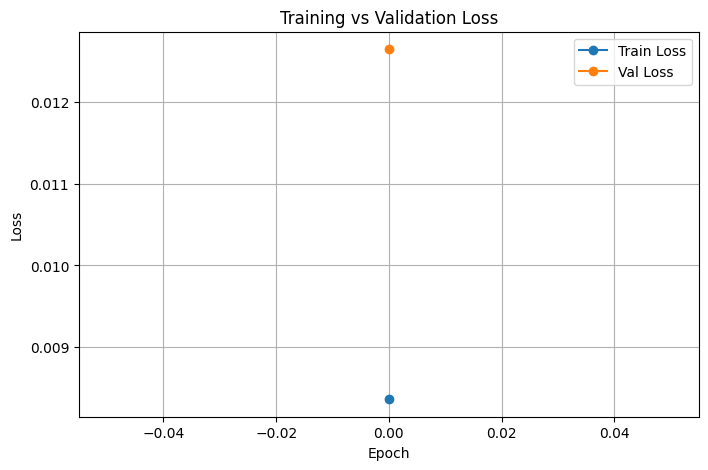

Epoch 2/20 => Train Loss: 0.00704 | Val Loss: 0.01154


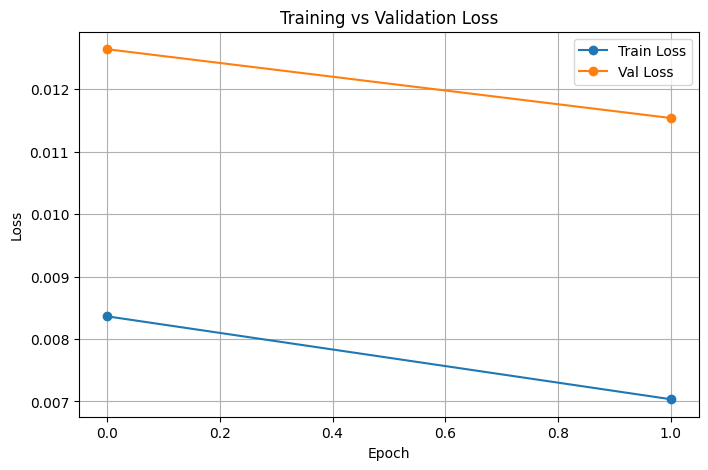

Epoch 3/20 => Train Loss: 0.00681 | Val Loss: 0.01179


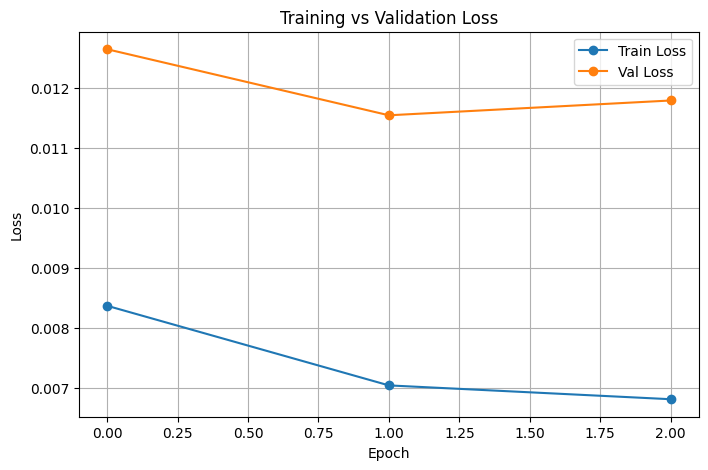

Epoch 4/20 => Train Loss: 0.00669 | Val Loss: 0.01178


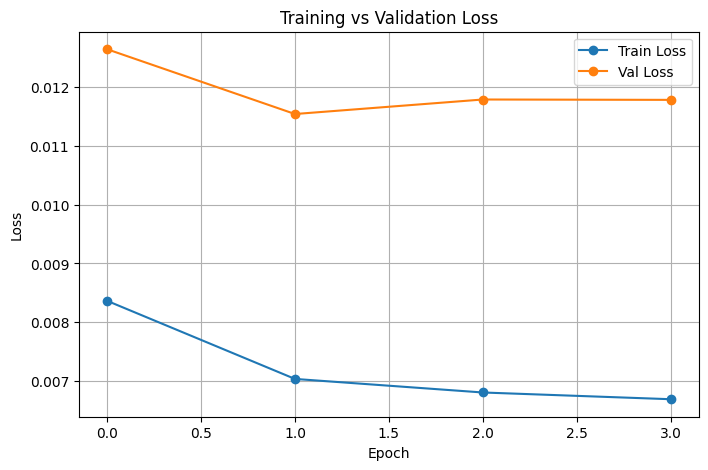

Epoch 5/20 => Train Loss: 0.00649 | Val Loss: 0.01157


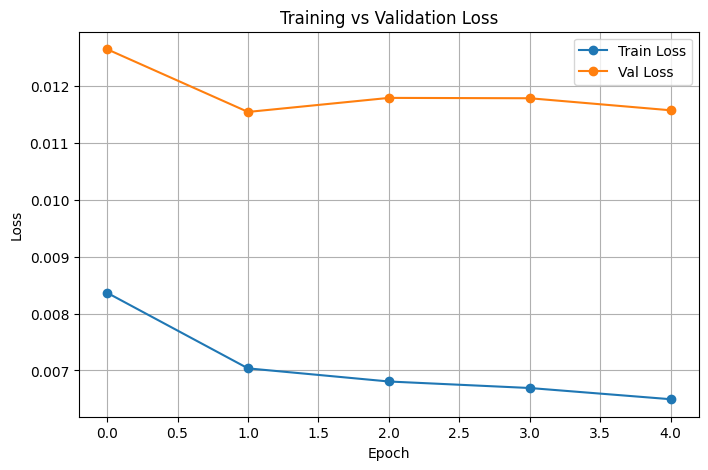

Epoch 6/20 => Train Loss: 0.00658 | Val Loss: 0.01156


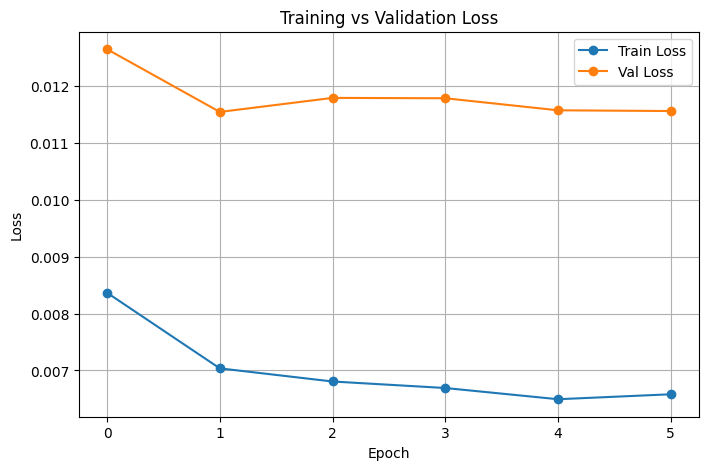

Epoch 7/20 => Train Loss: 0.00630 | Val Loss: 0.01169


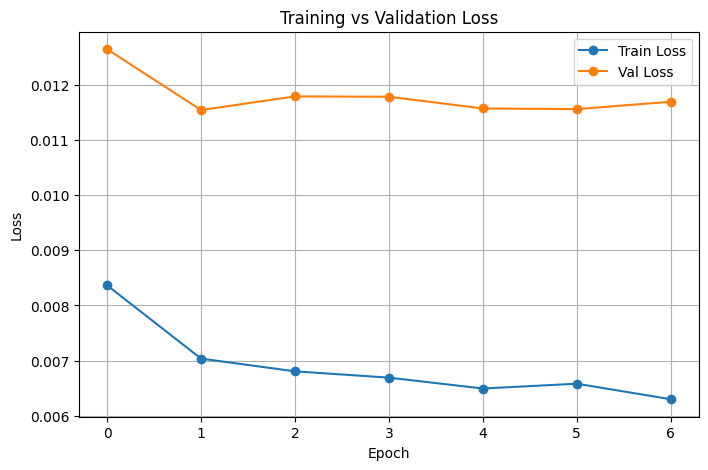

Epoch 8/20 => Train Loss: 0.00624 | Val Loss: 0.01161


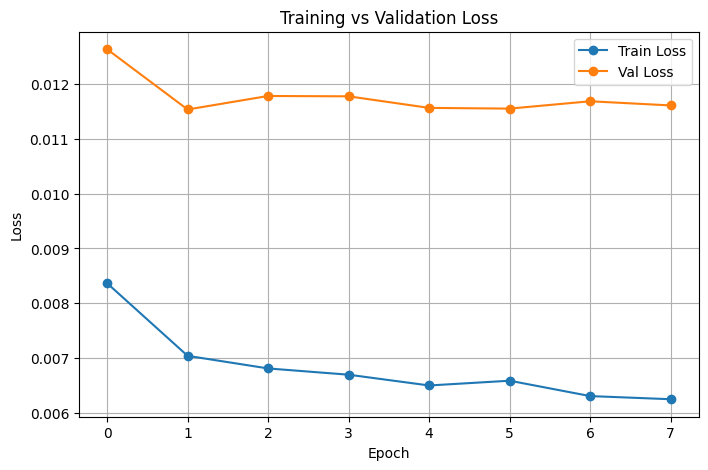

Epoch 9/20 => Train Loss: 0.00613 | Val Loss: 0.01144


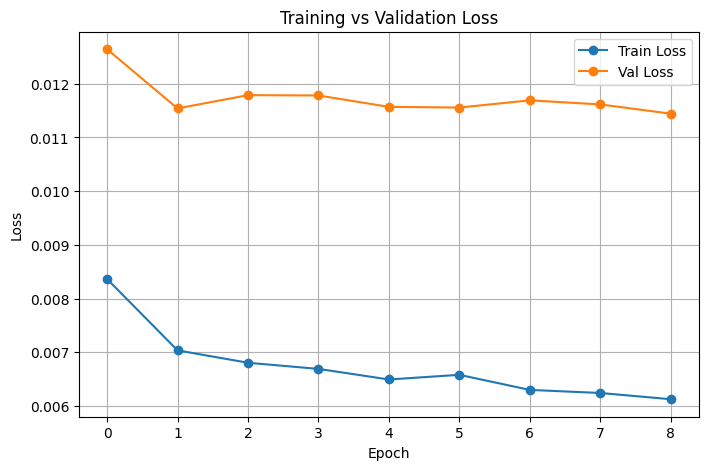

Epoch 10/20 => Train Loss: 0.00609 | Val Loss: 0.01115


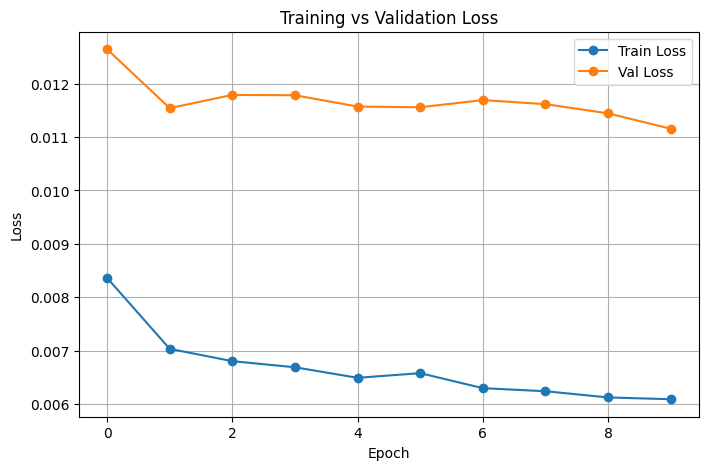

Epoch 11/20 => Train Loss: 0.00606 | Val Loss: 0.01107


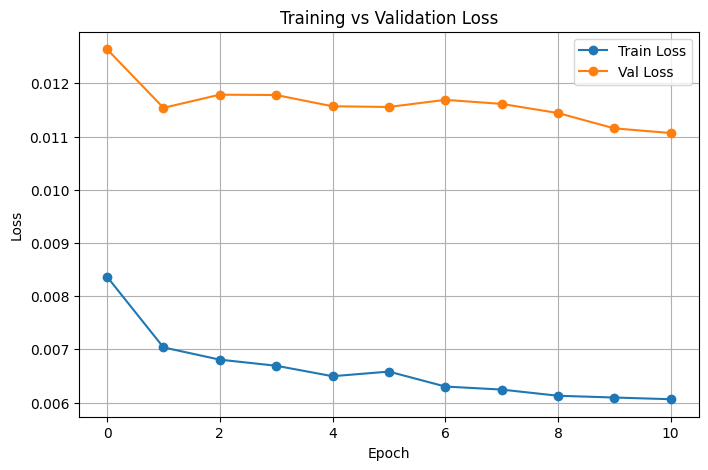

Epoch 12/20 => Train Loss: 0.00605 | Val Loss: 0.01098


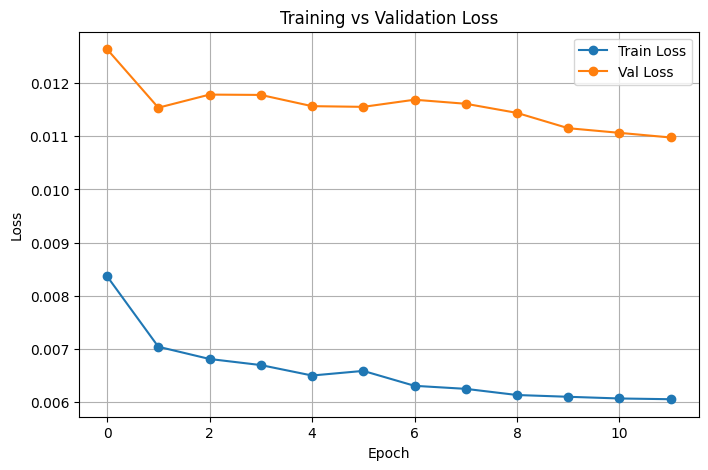

Epoch 13/20 => Train Loss: 0.00603 | Val Loss: 0.01097


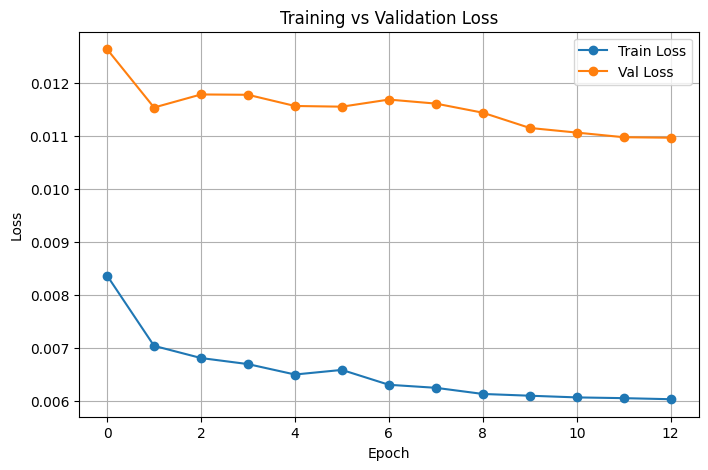

Epoch 14/20 => Train Loss: 0.00602 | Val Loss: 0.01106


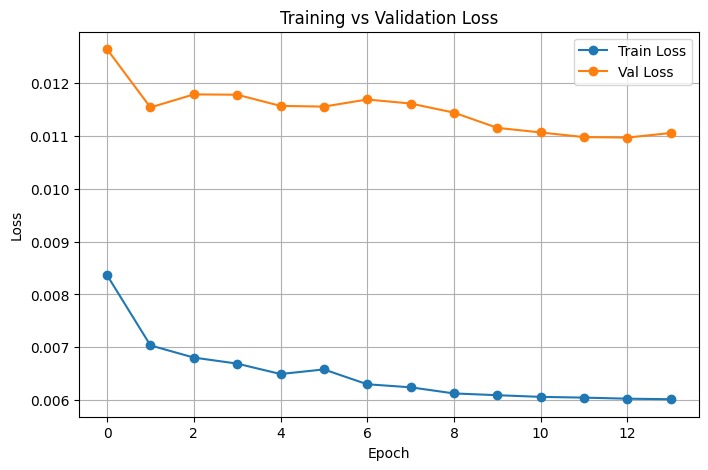

Epoch 15/20 => Train Loss: 0.00600 | Val Loss: 0.01117


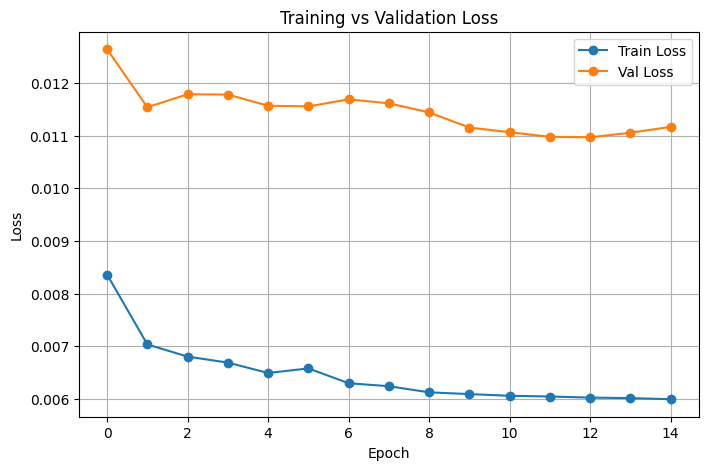

Epoch 16/20 => Train Loss: 0.00598 | Val Loss: 0.01132


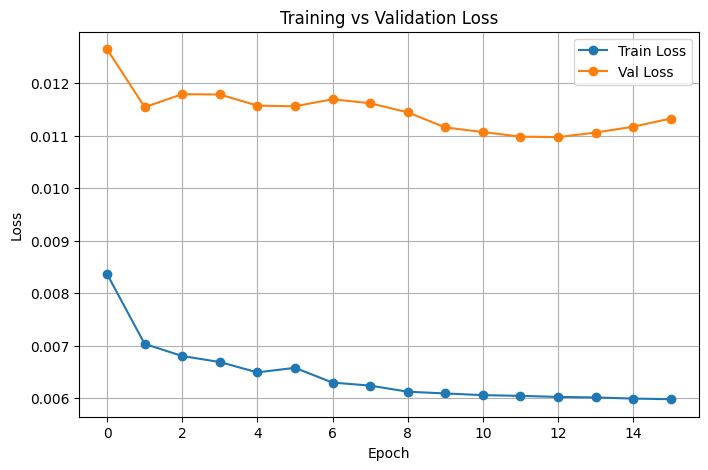

Epoch 17/20 => Train Loss: 0.00597 | Val Loss: 0.01140


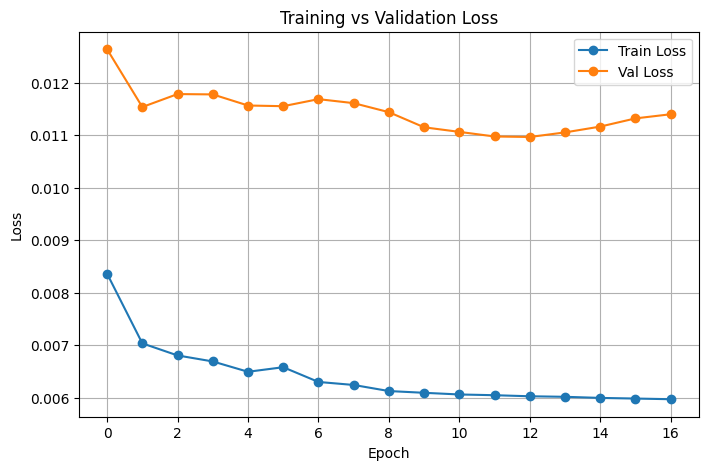

Epoch 18/20 => Train Loss: 0.00585 | Val Loss: 0.01129


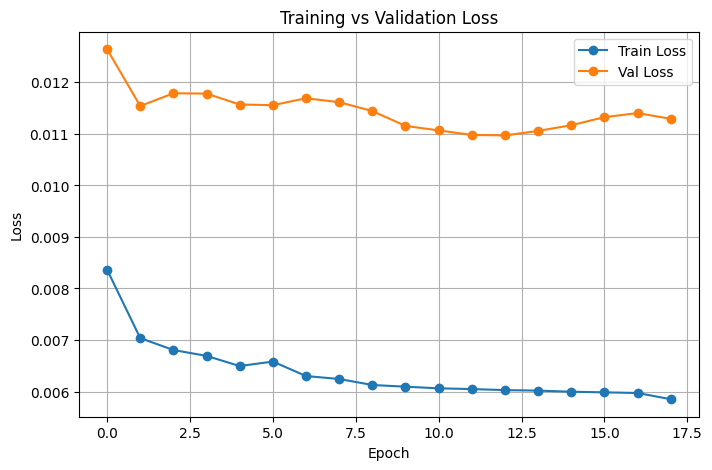

Epoch 19/20 => Train Loss: 0.00584 | Val Loss: 0.01118


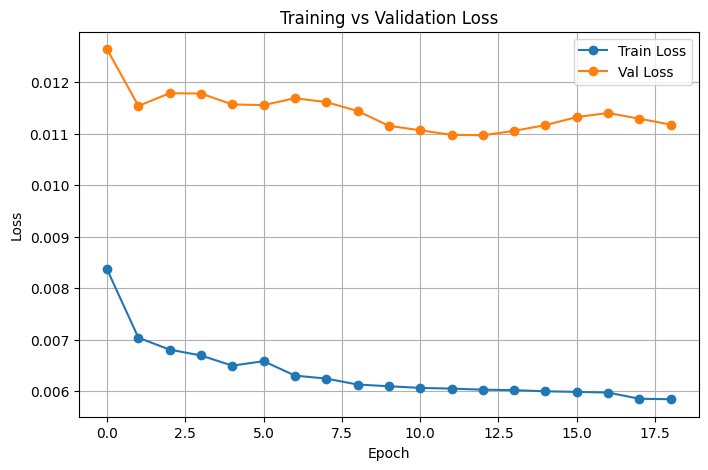

Epoch 20/20 => Train Loss: 0.00583 | Val Loss: 0.01146


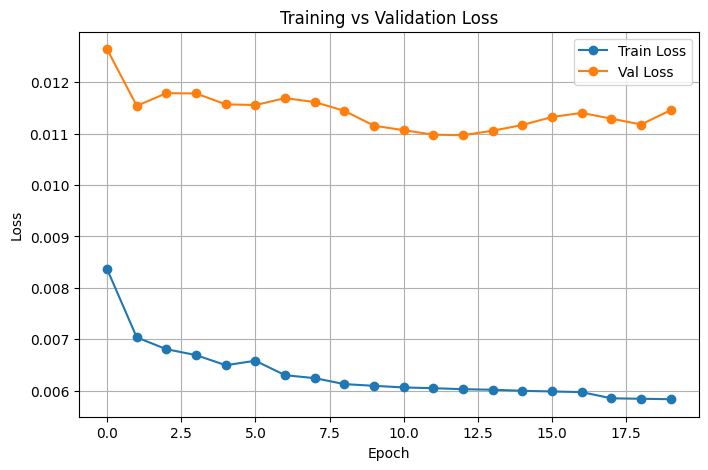

In [28]:
num_epochs = 20
train_losses_all = []
val_losses_all = []

for epoch in range(num_epochs):
    model_ffn.train()
    train_losses = []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch = y_batch.view(-1, 1)

        optimizer_ffn.zero_grad()
        preds = model_ffn(X_batch)
        loss = loss_fn_ffn(preds, y_batch)
        loss.backward()
        optimizer_ffn.step()

        train_losses.append(loss.item())

    model_ffn.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.view(-1, 1)
            preds = model_ffn(X_batch)
            loss = loss_fn_ffn(preds, y_batch)
            val_losses.append(loss.item())
    
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    
    train_losses_all.append(train_loss)
    val_losses_all.append(val_loss)
    
    scheduler_ffn.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} => Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")

    plt.figure(figsize=(8,5))
    plt.plot(train_losses_all, label='Train Loss', marker='o')
    plt.plot(val_losses_all, label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.grid(True)
    plt.show()

### Model Eval

In [30]:
from sklearn.metrics import r2_score,mean_absolute_error

model_ffn.eval()
predictions_ffn = []
y_actual = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_batch = y_batch.view(-1, 1)
        preds = model_ffn(X_batch)
        
        predictions_ffn.append(preds.cpu().numpy())
        y_actual.append(y_batch.cpu().numpy())

predictions_ffn = np.concatenate(predictions_ffn)
y_actual = np.concatenate(y_actual)

mse = np.mean((predictions_ffn - y_actual)**2)
print(f"Test MSE: {mse:.5f}")
mae=mean_absolute_error(torch.tensor(predictions_ffn),torch.tensor(y_actual))
print(f"Test MAE: {mae:.5f}")
rmse= np.sqrt(mse)
print(f"Test RMSE: {rmse:.5f}")
r2 = r2_score(y_actual, predictions_ffn)
print(f"R2 Score: {r2:.5f}")


Test MSE: 0.00451
Test MAE: 0.04200
Test RMSE: 0.06715
R2 Score: 0.76329


### Save Model

In [ ]:
# Save model param
torch.save({
    'epoch': epoch,
    'model_state_dict': model_ffn.state_dict(),
    'optimizer_state_dict': optimizer_ffn.state_dict(),
    'loss': loss,
}, '/kaggle/working/model_ffn.pth')

## LSTM

### Initial Model Def

In [ ]:
import torch.nn as nn

class SoCPredictorLSTM(nn.Module):
    def __init__(self, input_size=5, hidden_size=128, num_layers=2, dropout=0.3):
        super(SoCPredictorLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        last_output = output[:, -1, :]
        out = self.fc(last_output)
        return out.squeeze()


### Training Setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lstm = SoCPredictorLSTM(input_size=5).to(device)

optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)
loss_fn_lstm = nn.MSELoss()

# Optional: Learning rate scheduler (helps training)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_lstm, mode='min', factor=0.5, patience=5)

### Training Loop

In [ ]:
num_epochs = 20
train_losses_all = []
val_losses_all = []

for epoch in range(num_epochs):
    model_lstm.train()
    train_losses = []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch = y_batch.view(-1, 1)

        optimizer_lstm.zero_grad()
        preds = model_lstm(X_batch)
        loss = loss_fn_lstm(preds, y_batch)
        loss.backward()
        optimizer_lstm.step()

        train_losses.append(loss.item())

    model_lstm.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.view(-1, 1)
            preds = model_lstm(X_batch)
            loss = loss_fn_lstm(preds, y_batch)
            val_losses.append(loss.item())
    
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    
    train_losses_all.append(train_loss)
    val_losses_all.append(val_loss)
    
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} => Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")

    plt.figure(figsize=(8,5))
    plt.plot(train_losses_all, label='Train Loss', marker='o')
    plt.plot(val_losses_all, label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.grid(True)
    plt.show()

### Model Eval

In [56]:
from sklearn.metrics import r2_score,mean_absolute_error

model_lstm.eval()
predictions_lstm = []
y_actual = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model_lstm(X_batch)
        
        predictions_lstm.append(preds.cpu().numpy())
        y_actual.append(y_batch.numpy())

predictions_lstm = np.concatenate(predictions_lstm)
y_actual = np.concatenate(y_actual)

mse = np.mean((predictions_lstm - y_actual)**2)
print(f"Test MSE: {mse:.5f}")
mae=mean_absolute_error(torch.tensor(predictions_lstm),torch.tensor(y_actual))
print(f"Test MAE: {mae:.5f}")
rmse= np.sqrt(mse)
print(f"Test RMSE: {rmse:.5f}")
r2 = r2_score(y_actual, predictions_lstm)
print(f"R2 Score: {r2:.5f}")


Test MSE: 0.00136
Test RMSE: 0.03685
R2 Score: 0.92872


### Save Model

In [ ]:
# Save model param
torch.save({
    'epoch': epoch,
    'model_state_dict': model_lstm.state_dict(),
    'optimizer_state_dict': optimizer_lstm.state_dict(),
    'loss': loss,
}, '/kaggle/working/model_1.pth')

In [ ]:
#reload model
model_lstm = LSTMModel(...)  # Define your model structure
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)
checkpoint_lstm = torch.load('/kaggle/working/model_1.pth')
model_lstm.load_state_dict(checkpoint_lstm['model_state_dict'])
optimizer_lstm.load_state_dict(checkpoint_lstm['optimizer_state_dict'])
epoch = checkpoint_lstm['epoch']
loss = checkpoint_lstm['loss']

## Bi-LSTM

### Model Def

In [57]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2):
        super(BiLSTMModel, self).__init__()
        
        self.bilstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 64),  # ×2 for bidirectional
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        lstm_out, _ = self.bilstm(x)      # lstm_out: (batch_size, seq_len, hidden_size * 2)
        last_out = lstm_out[:, -1, :]      # Take last time step output
        out = self.fc(last_out)
        return out

### Trainig Setup

In [58]:
# Define the model
input_size = X_train.shape[2]  # Should be 6 if you use (Voltage, Current, Temp, etc + delta_t if added)
model_bilstm = BiLSTMModel(input_size=input_size, hidden_size=128, num_layers=2)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bilstm = model_bilstm.to(device)

# Define optimizer and loss
optimizer_bilstm = torch.optim.Adam(model_bilstm.parameters(), lr=1e-3)
loss_fn_bilstm = nn.MSELoss()
scheduler_bilstm = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_bilstm, mode='min', patience=3, factor=0.5)


### Training Loop

Epoch 1/20 => Train Loss: 0.00079 | Val Loss: 0.00738


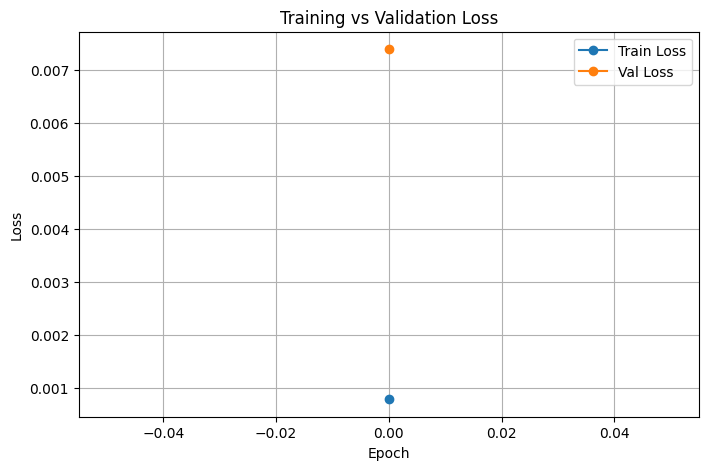

Epoch 2/20 => Train Loss: 0.00016 | Val Loss: 0.00744


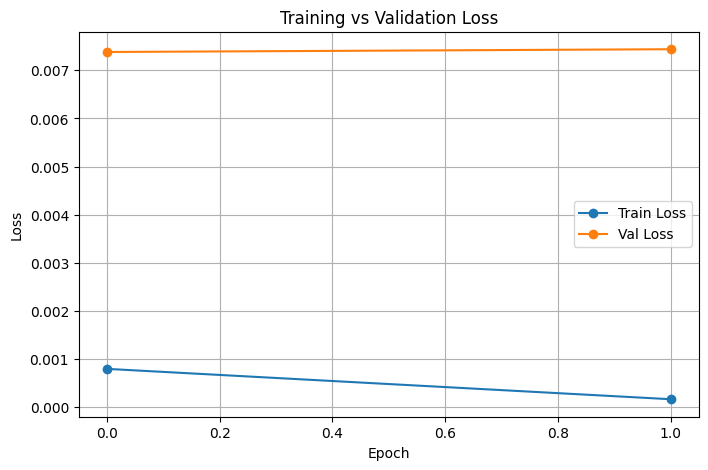

Epoch 3/20 => Train Loss: 0.00011 | Val Loss: 0.00782


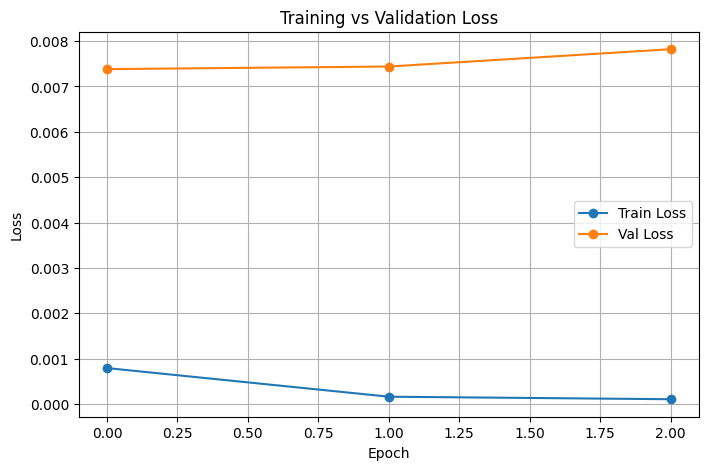

Epoch 4/20 => Train Loss: 0.00008 | Val Loss: 0.00745


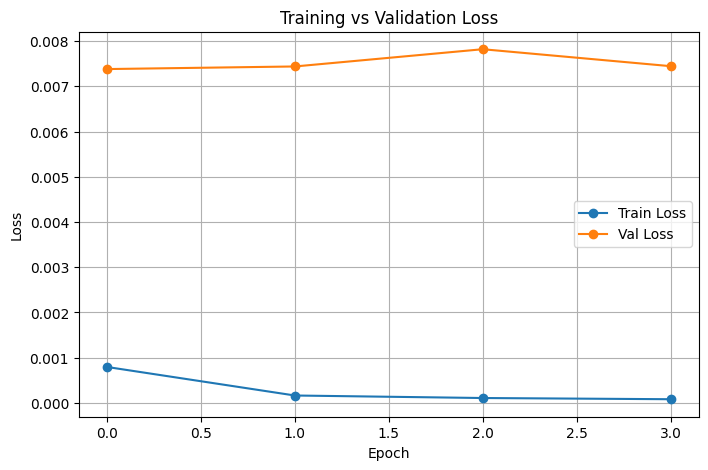

Epoch 5/20 => Train Loss: 0.00007 | Val Loss: 0.00738


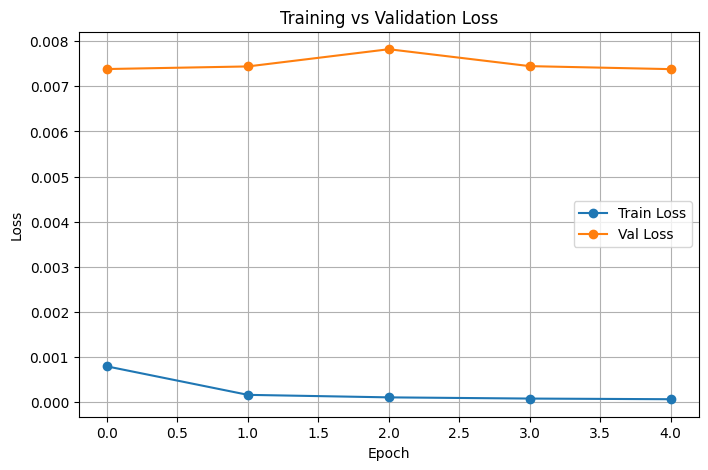

Epoch 6/20 => Train Loss: 0.00006 | Val Loss: 0.00763


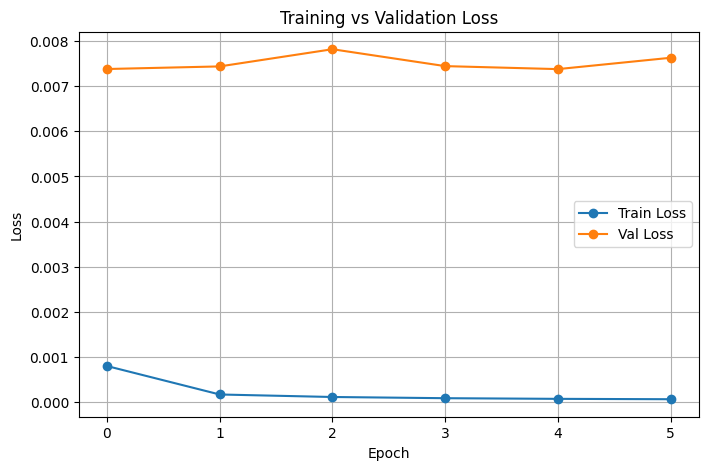

Epoch 7/20 => Train Loss: 0.00005 | Val Loss: 0.00764


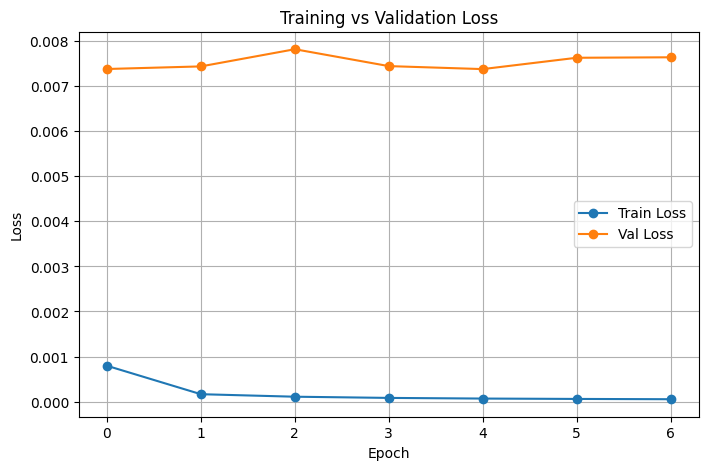

Epoch 8/20 => Train Loss: 0.00005 | Val Loss: 0.00716


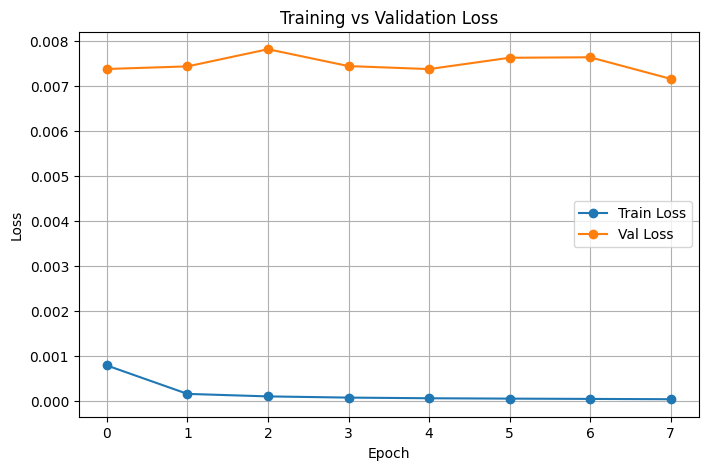

Epoch 9/20 => Train Loss: 0.00004 | Val Loss: 0.00710


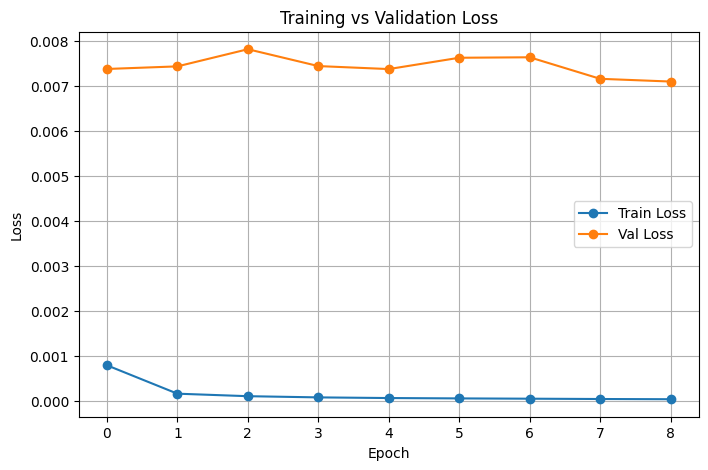

Epoch 10/20 => Train Loss: 0.00004 | Val Loss: 0.00749


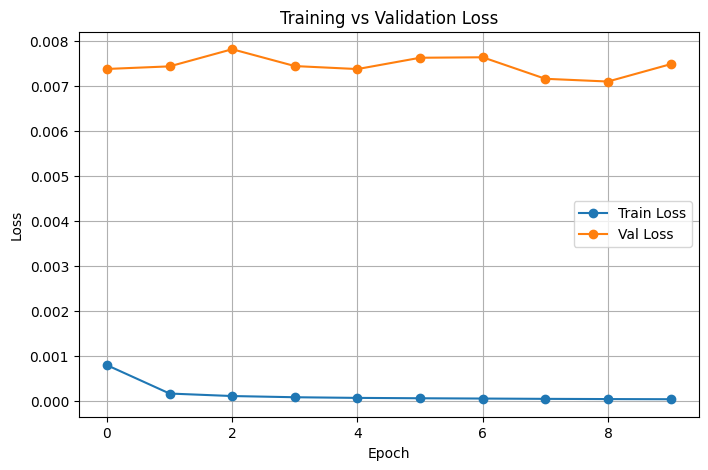

Epoch 11/20 => Train Loss: 0.00003 | Val Loss: 0.00738


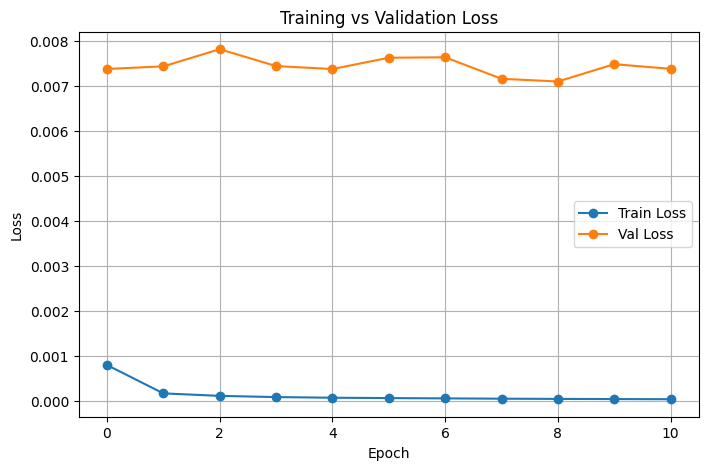

Epoch 12/20 => Train Loss: 0.00004 | Val Loss: 0.00765


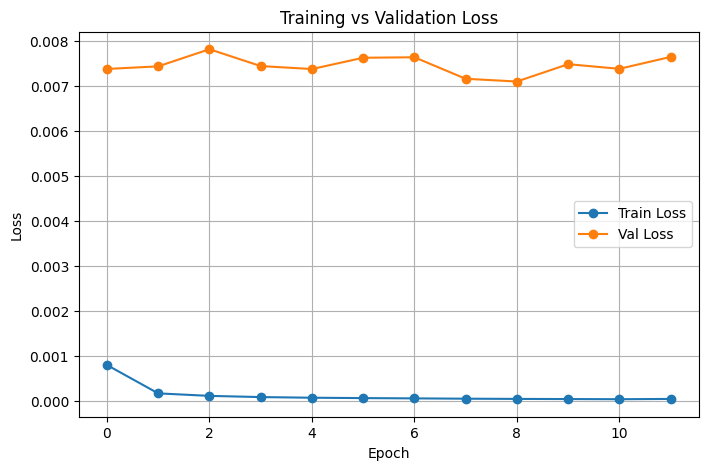

Epoch 13/20 => Train Loss: 0.00003 | Val Loss: 0.00802


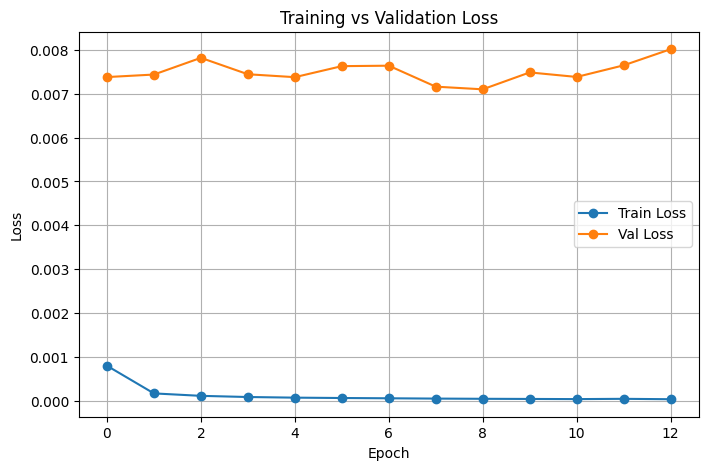

Epoch 14/20 => Train Loss: 0.00003 | Val Loss: 0.00783


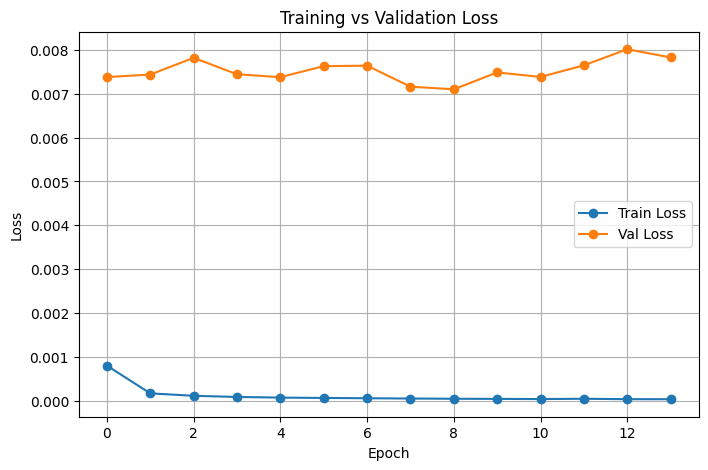

Epoch 15/20 => Train Loss: 0.00003 | Val Loss: 0.00762


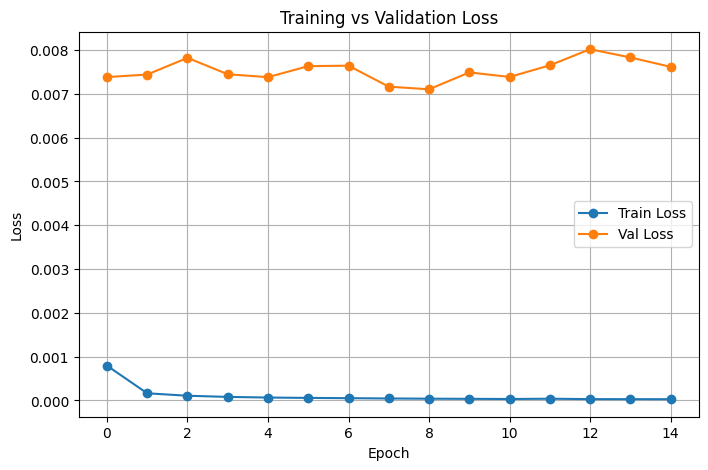

Epoch 16/20 => Train Loss: 0.00003 | Val Loss: 0.00791


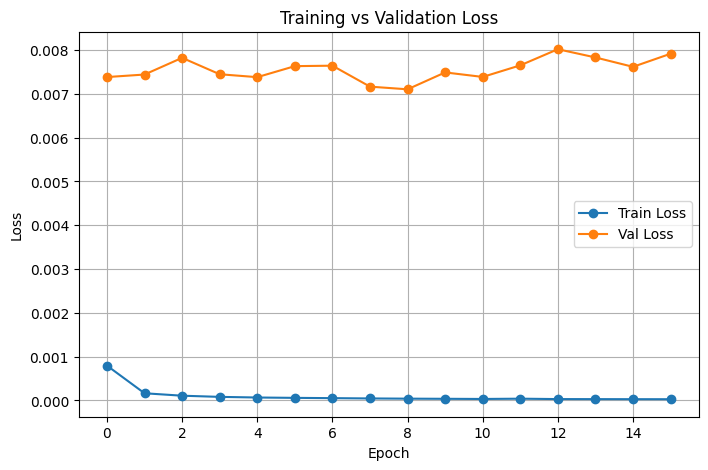

Epoch 17/20 => Train Loss: 0.00003 | Val Loss: 0.00774


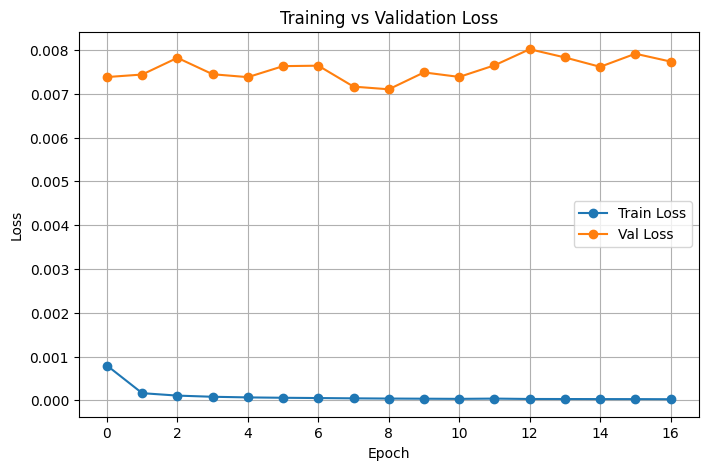

Epoch 18/20 => Train Loss: 0.00002 | Val Loss: 0.00781


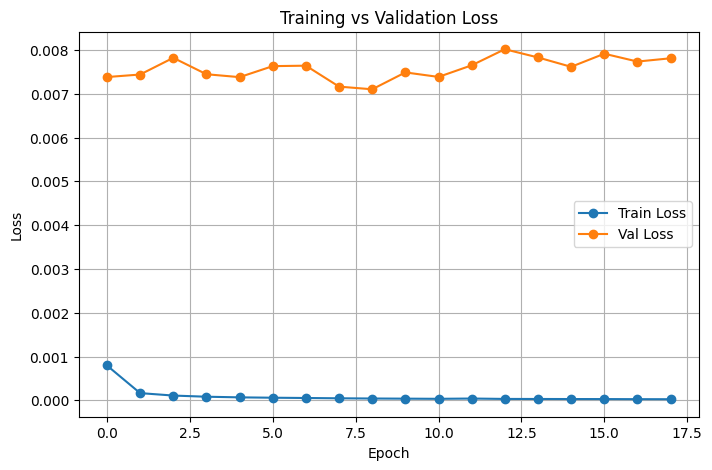

Epoch 19/20 => Train Loss: 0.00003 | Val Loss: 0.00785


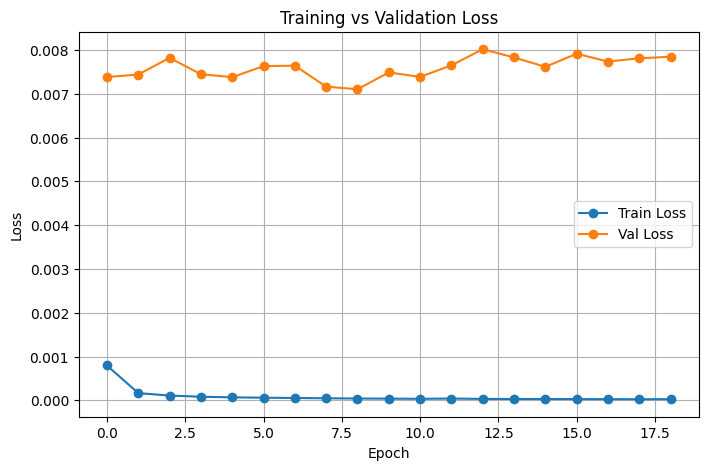

Epoch 20/20 => Train Loss: 0.00002 | Val Loss: 0.00797


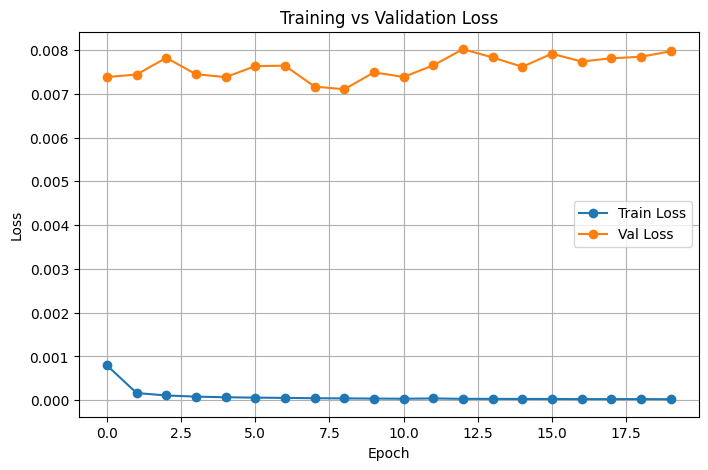

In [61]:
num_epochs = 20
train_losses_all = []
val_losses_all = []

for epoch in range(num_epochs):
    model_bilstm.train()
    train_losses = []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch = y_batch.view(-1, 1)

        optimizer_bilstm.zero_grad()
        preds = model_bilstm(X_batch)
        loss = loss_fn_bilstm(preds, y_batch)
        loss.backward()
        optimizer_bilstm.step()

        train_losses.append(loss.item())

    model_bilstm.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.view(-1, 1)
            preds = model_bilstm(X_batch)
            loss = loss_fn_bilstm(preds, y_batch)
            val_losses.append(loss.item())
    
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    
    train_losses_all.append(train_loss)
    val_losses_all.append(val_loss)
    
    scheduler_bilstm.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} => Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")

    plt.figure(figsize=(8,5))
    plt.plot(train_losses_all, label='Train Loss', marker='o')
    plt.plot(val_losses_all, label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.grid(True)
    plt.show()

### Model Eval

In [63]:
from sklearn.metrics import r2_score,mean_absolute_error
from torch.nn import MSELoss

model_bilstm.eval()
predictions_bilstm = []
y_actual = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_batch = y_batch.view(-1, 1)
        preds = model_bilstm(X_batch)
        
        predictions_bilstm.append(preds.cpu().numpy())
        y_actual.append(y_batch.cpu().numpy())

predictions_bilstm = np.concatenate(predictions_bilstm)
y_actual = np.concatenate(y_actual)

mse_loss_fn_bilstm = MSELoss()
mse = mse_loss_fn_bilstm(torch.tensor(predictions_bilstm), torch.tensor(y_actual))
rmse = torch.sqrt(mse)

mae=mean_absolute_error(torch.tensor(predictions_bilstm),torch.tensor(y_actual))

r2 = r2_score(y_actual, predictions_bilstm)

print(f"Test MSE: {mse.item():.5f}")
print(f"Test MAE: {mae.item():.5f}")
print(f"Test RMSE: {rmse.item():.5f}")
print(f"Test R2 Score: {r2:.5f}")


Test MSE: 0.00154
Test RMSE: 0.03920
Test R2 Score: 0.91933


### Save Model

In [64]:
# Save Bi-LSTM model state
torch.save({
    'epoch': epoch,
    'model_state_dict': model_bilstm.state_dict(),
    'optimizer_state_dict': optimizer_bilstm.state_dict(),
    'loss': loss,
}, '/kaggle/working/model_bilstm.pth')


## GRU

### Model Def

In [73]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, h_n = self.gru(x)
        out = h_n[-1]  # last layer's hidden state
        return self.fc(out)

### Training Setup

In [75]:
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2

model_gru = GRUModel(input_size, hidden_size, num_layers).to(device)

loss_fn_gru = nn.MSELoss()
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=0.001)
scheduler_gru = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_gru, mode='min', patience=3, factor=0.5)

### Training Loop

[GRU] Epoch 1/20 => Train Loss: 0.00114 | Val Loss: 0.00861


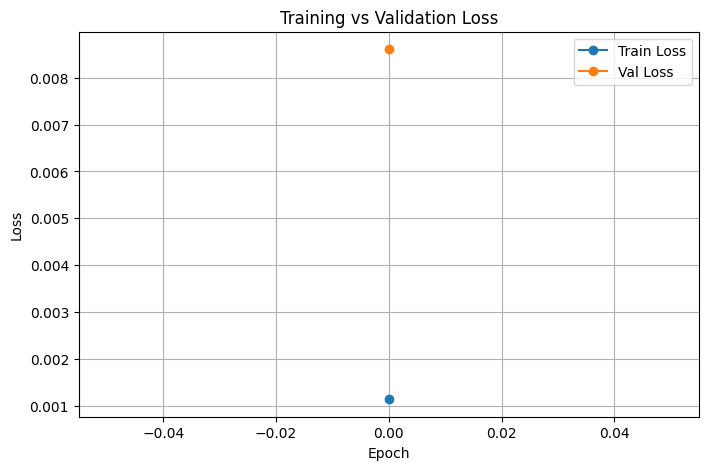

[GRU] Epoch 2/20 => Train Loss: 0.00041 | Val Loss: 0.00807


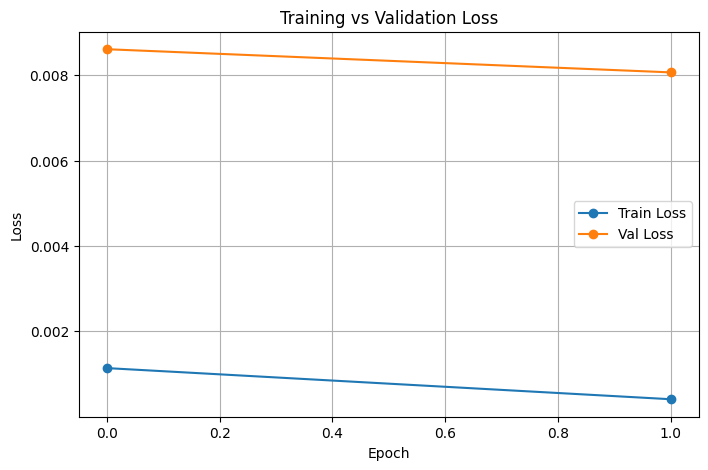

[GRU] Epoch 3/20 => Train Loss: 0.00019 | Val Loss: 0.00812


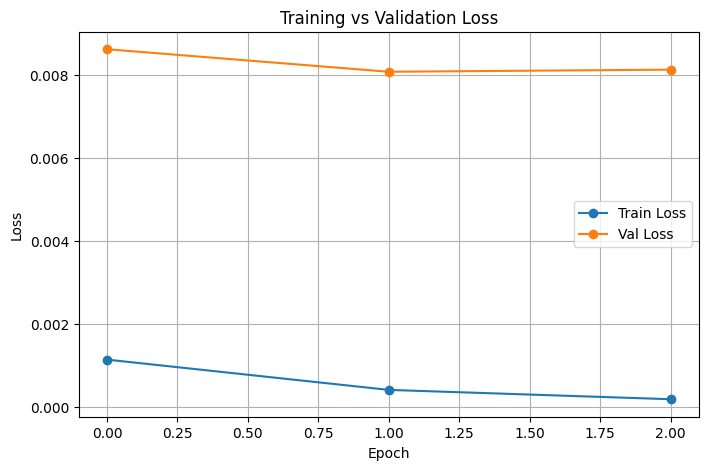

[GRU] Epoch 4/20 => Train Loss: 0.00013 | Val Loss: 0.00825


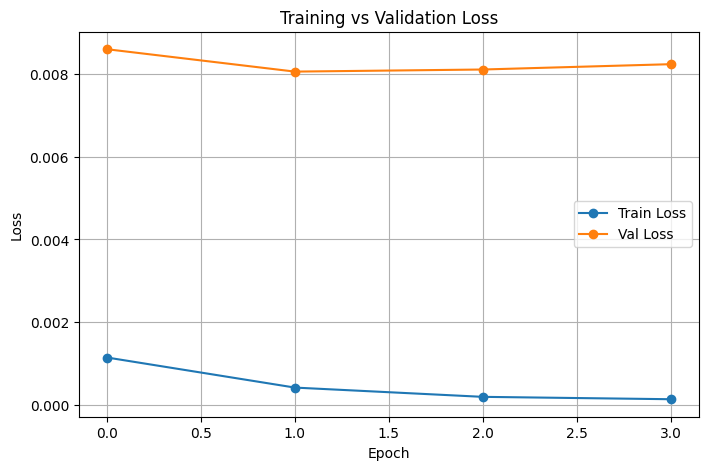

[GRU] Epoch 5/20 => Train Loss: 0.00011 | Val Loss: 0.00807


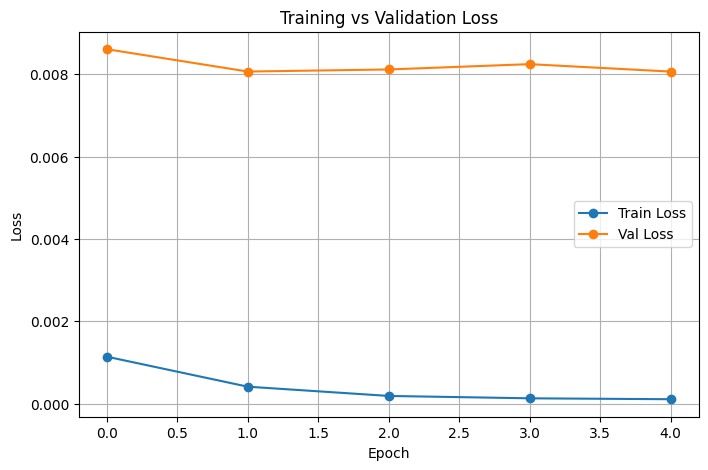

[GRU] Epoch 6/20 => Train Loss: 0.00009 | Val Loss: 0.00851


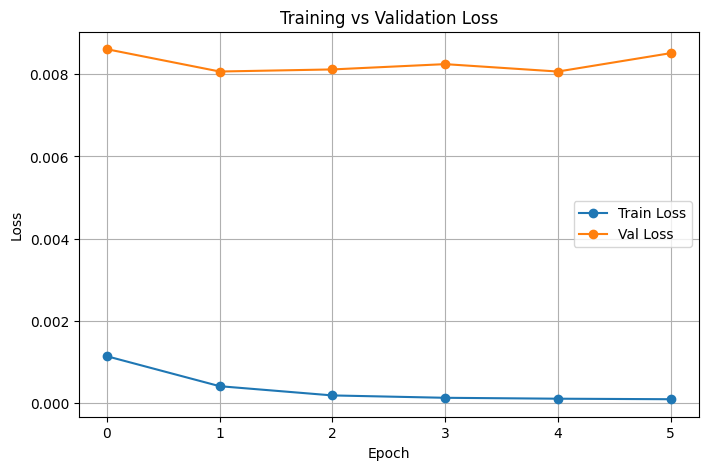

[GRU] Epoch 7/20 => Train Loss: 0.00005 | Val Loss: 0.00795


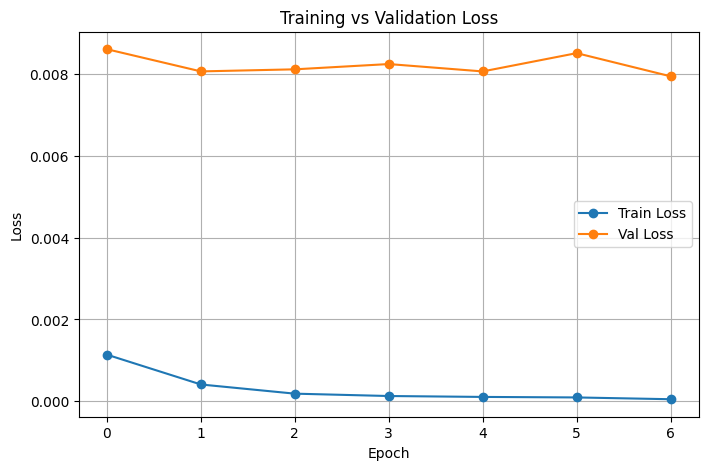

[GRU] Epoch 8/20 => Train Loss: 0.00005 | Val Loss: 0.00814


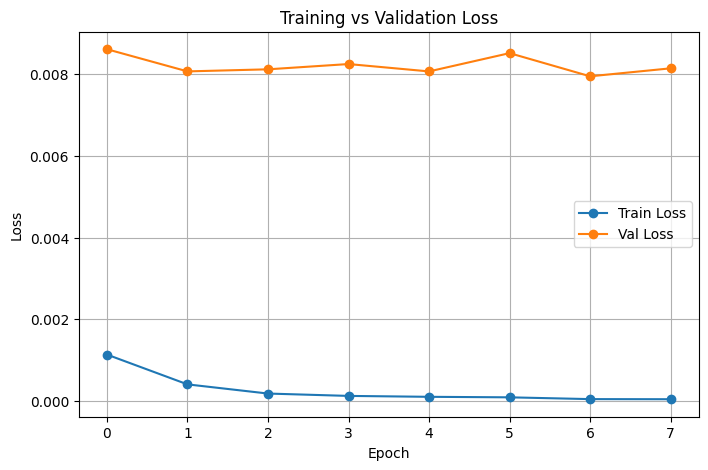

[GRU] Epoch 9/20 => Train Loss: 0.00005 | Val Loss: 0.00747


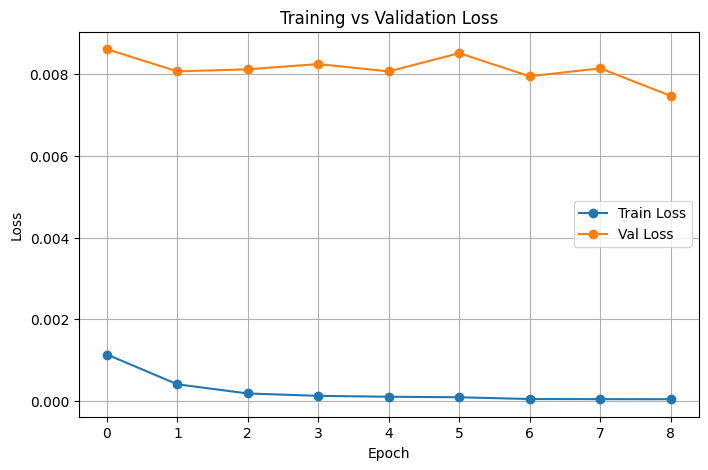

[GRU] Epoch 10/20 => Train Loss: 0.00004 | Val Loss: 0.00747


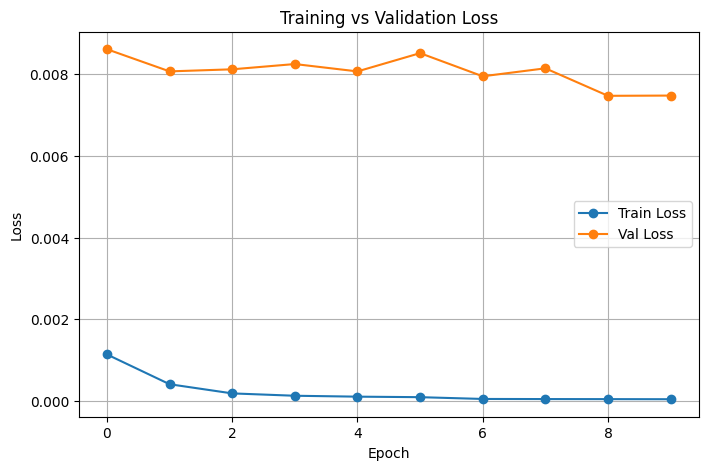

[GRU] Epoch 11/20 => Train Loss: 0.00004 | Val Loss: 0.00783


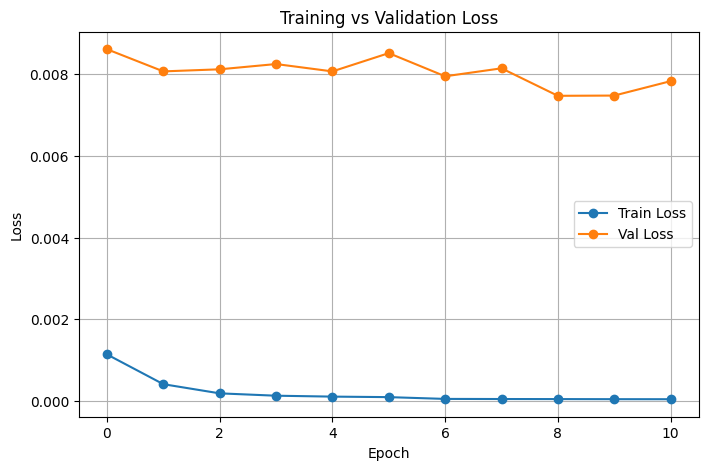

[GRU] Epoch 12/20 => Train Loss: 0.00004 | Val Loss: 0.00783


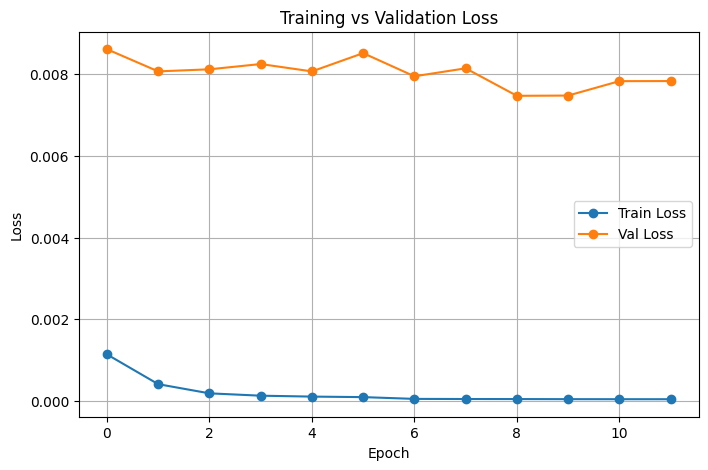

[GRU] Epoch 13/20 => Train Loss: 0.00004 | Val Loss: 0.00764


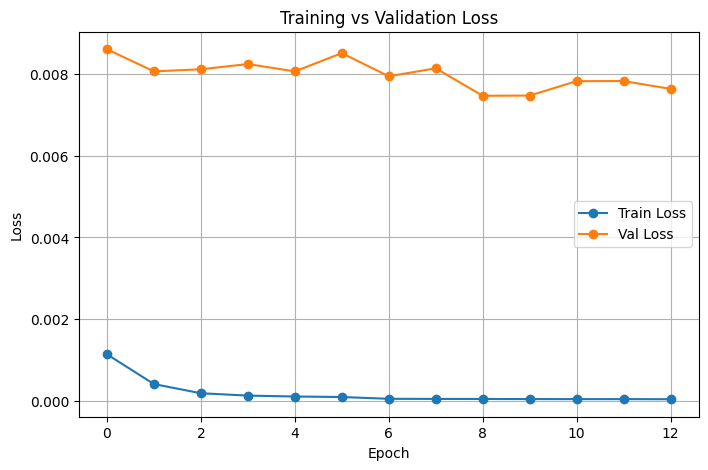

[GRU] Epoch 14/20 => Train Loss: 0.00002 | Val Loss: 0.00745


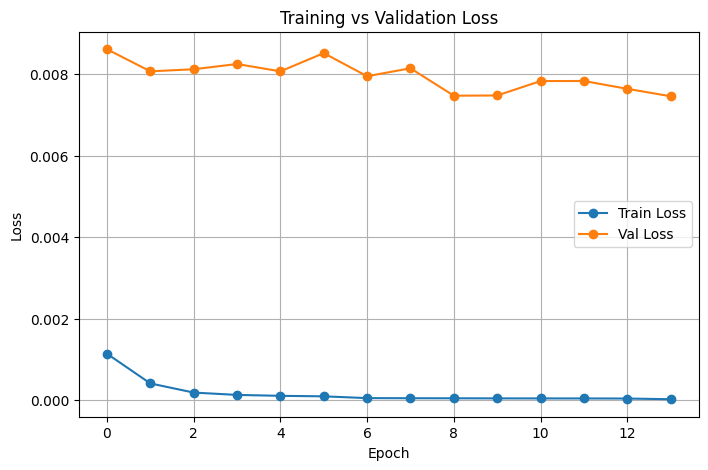

[GRU] Epoch 15/20 => Train Loss: 0.00002 | Val Loss: 0.00735


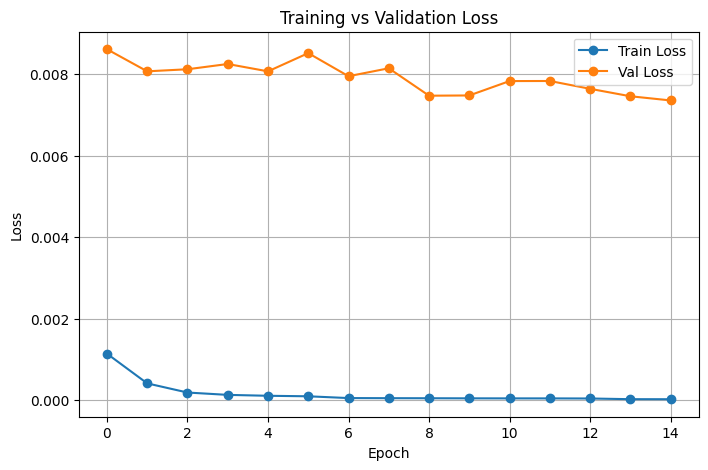

[GRU] Epoch 16/20 => Train Loss: 0.00002 | Val Loss: 0.00730


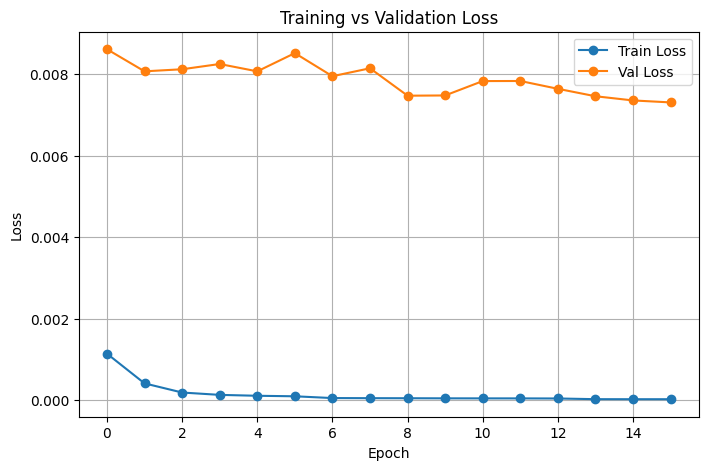

[GRU] Epoch 17/20 => Train Loss: 0.00002 | Val Loss: 0.00714


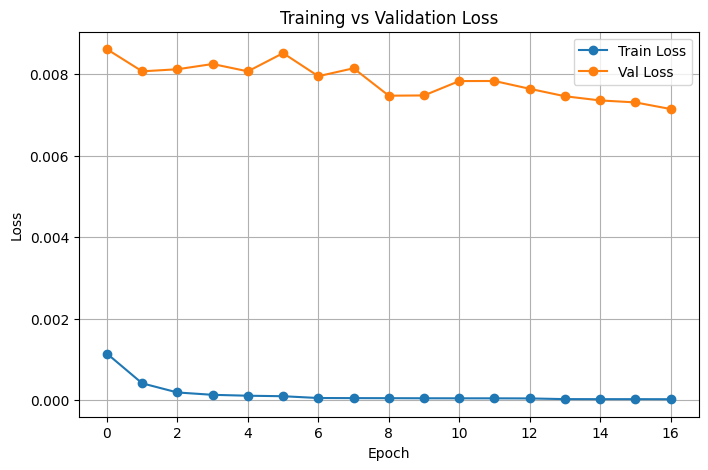

[GRU] Epoch 18/20 => Train Loss: 0.00002 | Val Loss: 0.00751


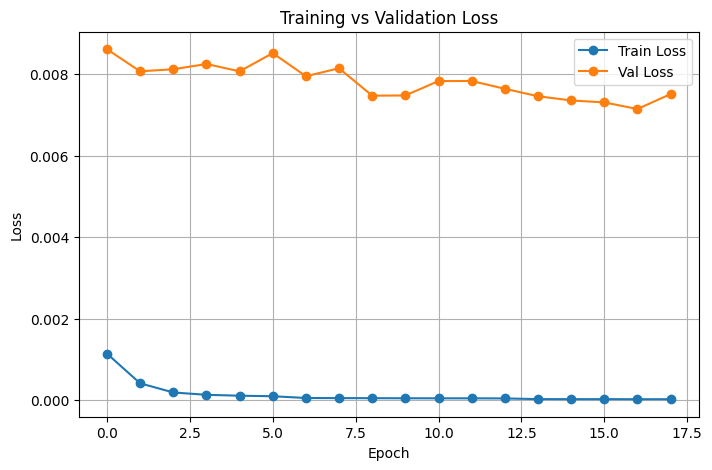

[GRU] Epoch 19/20 => Train Loss: 0.00002 | Val Loss: 0.00681


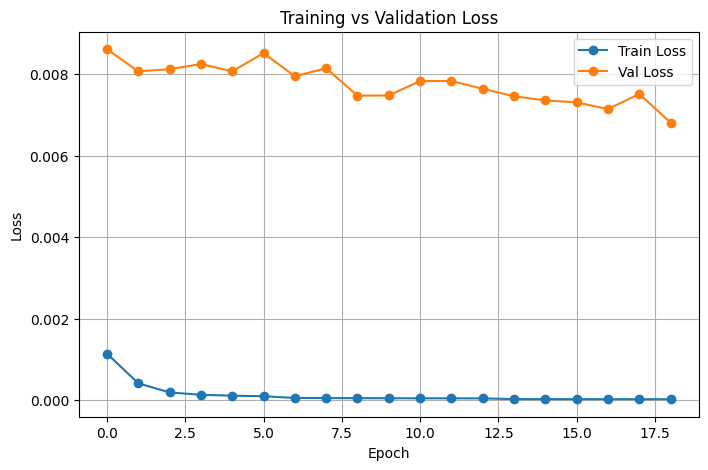

[GRU] Epoch 20/20 => Train Loss: 0.00002 | Val Loss: 0.00683


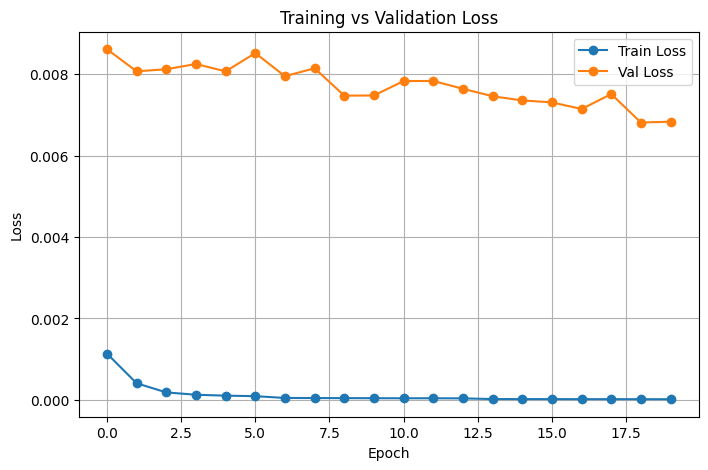

In [76]:
num_epochs = 20
train_losses_all = []
val_losses_all = []

for epoch in range(num_epochs):
    model_gru.train()
    train_losses = []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)

        optimizer_gru.zero_grad()
        preds = model_gru(X_batch)
        loss = loss_fn_gru(preds, y_batch)
        loss.backward()
        optimizer_gru.step()

        train_losses.append(loss.item())

    model_gru.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)
            preds = model_gru(X_batch)
            loss = loss_fn_gru(preds, y_batch)
            val_losses.append(loss.item())
    
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    
    train_losses_all.append(train_loss)
    val_losses_all.append(val_loss)
    
    scheduler_gru.step(val_loss)

    print(f"[GRU] Epoch {epoch+1}/{num_epochs} => Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")

    plt.figure(figsize=(8,5))
    plt.plot(train_losses_all, label='Train Loss', marker='o')
    plt.plot(val_losses_all, label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.grid(True)
    plt.show()

### Model Eval

In [77]:
from sklearn.metrics import r2_score,mean_absolute_error
from torch.nn import MSELoss

model_gru.eval()
predictions_gru = []
y_actual = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_batch = y_batch.view(-1, 1)
        preds = model_gru(X_batch)
        predictions_gru.append(preds.cpu().numpy())
        y_actual.append(y_batch.cpu().numpy())

predictions_gru = np.concatenate(predictions_gru)
y_actual = np.concatenate(y_actual)

mse_loss_fn_gru = MSELoss()
mse = mse_loss_fn_gru(torch.tensor(predictions_gru), torch.tensor(y_actual))
rmse = torch.sqrt(mse)

mae=mean_absolute_error(torch.tensor(predictions_gru),torch.tensor(y_actual))

r2 = r2_score(y_actual, predictions_gru)

print(f"Test MSE: {mse.item():.5f}")
print(f"Test MAE: {mae.item():.5f}")
print(f"Test RMSE: {rmse.item():.5f}")
print(f"Test R2 Score: {r2:.5f}")

Test MSE: 0.00104
Test RMSE: 0.03231
Test R2 Score: 0.94518


### Saving Model

In [79]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model_gru.state_dict(),
    'optimizer_state_dict': optimizer_gru.state_dict(),
    'loss': loss.item(),  # final loss
}, '/kaggle/working/gru_model.pth')

## All Model Scores

In [35]:
scores={
    'ffn':{
        'mse':0.00451,
        'mae':0.04200,
        'rmse':0.06715,
        'r2': 0.76329
    },
    'lstm':{
        'mse':0.00136,
        'mae':0.01632585,
        'rmse':0.03685,
        'r2':0.92872
    },
    'bi-lstm':{
        'mse':0.00154,
        'mae':0.01858212,
        'rmse':0.03920,
        'r2':0.91933
    },
    'gru':{
        'mse':0.00104,
        'mae':0.015839234,
        'rmse':0.03231,
        'r2':0.94518
    }
}

In [84]:
import json

with open("/kaggle/working/model_scores.json", "w") as f:
    json.dump(scores, f, indent=4)

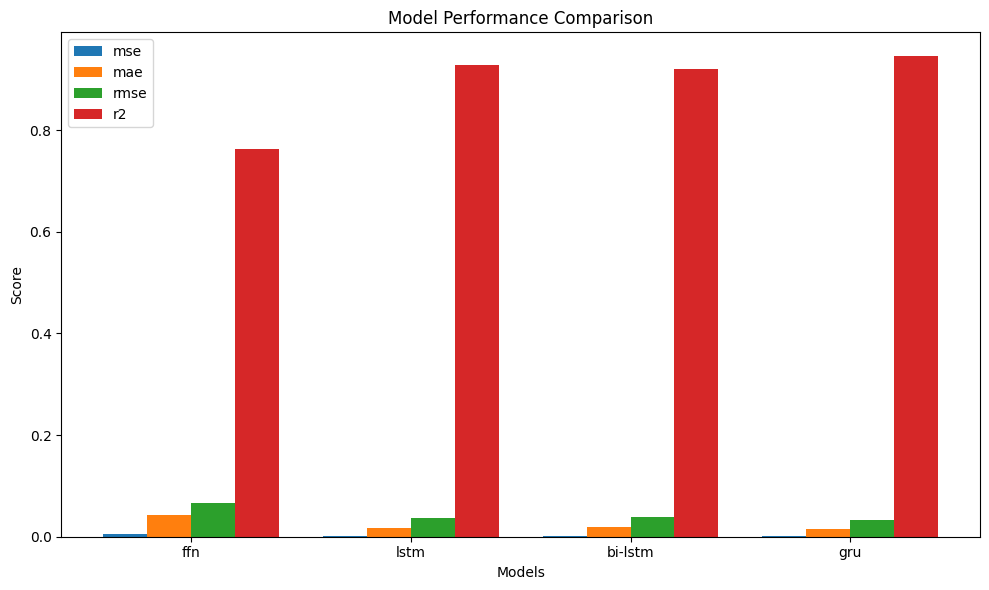

In [38]:
models=['ffn','lstm','bi-lstm','gru']
metrics=['mse','mae','rmse','r2']
metric_values = np.array([[scores[model][metric] for metric in metrics] for model in models])

# Create bar plot for each metric (grouped by model)
x = np.arange(len(models))  # x positions for the models
width = 0.2  # bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each metric for each model (stacked bars)
for i, metric in enumerate(metrics):
    ax.bar(x + (i - 1.5) * width, metric_values[:, i], width, label=metric)

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

# PREDICTING SOH BASED ON SOC 

In [ ]:
metadata_df = pd.read_csv("/kaggle/input/nasa-battery-dataset/cleaned_dataset/metadata.csv")
metadata_df

In [ ]:
capacity = metadata_df[metadata_df['battery_id']=='B0055'][metadata_df['type']=='discharge']
SOH_series = pd.to_numeric(capacity['Capacity'], errors='coerce')/ 1.6579955793677608
# capacity_series = capacity['Capacity']/ 1.6579955793677608
cycles = range(1,len(SOH_series)+1)
capacity_df = pd.DataFrame(columns = ['SOH', 'cycle'])
capacity_df['SOH'] = SOH_series
capacity_df['cycle'] = cycles
capacity_df

In [ ]:
plt.scatter(capacity_df['cycle'], capacity_df['SOH'])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [ ]:
seq_length = 2  # Number of past time steps to consider
X, y = create_sequences(cycles, seq_length)
num_features = 1
y = capacity_df['SOH'][seq_length:]
X_train, X_test, y_train, y_test = train_test_split(X[:35], y[:35], test_size=0.2, random_state=42)

In [ ]:
y[:30]

In [ ]:
model_GRU = Sequential()
model_GRU.add(GRU(units=20, return_sequences=True, input_shape=(seq_length, num_features)))
model_GRU.add(GRU(units=50, activation='relu'))
model_GRU.add(Dense(units=1))

In [ ]:
import time
model_GRU.compile(optimizer='adam', loss='mean_squared_error')

# Start timer
start_time = time.time()
history = model_GRU.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_test, y_test))
# End timer
end_time = time.time()

# Calculate the training duration
training_duration_GRU = end_time - start_time
print(f"Training time: {training_duration_GRU:.2f} seconds")

In [ ]:
loss = model_GRU.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

In [ ]:
predictions_GRU = model_GRU.predict(X)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
# import numpy as np

# Assuming y_test_actual contains the true values, and predictions contains the model predictions
mae_GRU = mean_absolute_error(y, predictions_GRU)
mse_GRU = mean_squared_error(y, predictions_GRU)
rmse_GRU = np.sqrt(mse_GRU)
mape_GRU = mean_absolute_percentage_error(y, predictions_GRU) * 100  # Convert to percentage
r2_GRU = r2_score(y, predictions_GRU)

print(f'Mean Absolute Error (MAE): {mae_GRU}')
print(f'Mean Squared Error (MSE): {mse_GRU}')
print(f'Root Mean Squared Error (RMSE): {rmse_GRU}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_GRU}%')
print(f'R-squared (R²): {r2_GRU}')

In [ ]:
residuals_GRU = y_test - predictions_GRU[0]

# plt.figure(figsize=(10, 6))
plt.scatter(capacity_df['cycle'][2:], predictions_GRU)
plt.scatter(capacity_df['cycle'][2:], y)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor


model_RF = RandomForestRegressor(random_state=0)
# Start timer
start_time = time.time()
model_RF.fit(X_train, y_train)
# End timer
end_time = time.time()

# Calculate the training duration
training_duration_RF = end_time - start_time
print(f"Training time: {training_duration_RF:.2f} seconds")

predictions_RF = model_RF.predict(X)
# preds = model_RF.predict(X_test)
mae_RF = mean_absolute_error(y, predictions_RF)
r2_RF = r2_score(y, predictions_RF)
print(f"MAE: {mae_RF}")
print(f"R2S: {r2_RF}")

# # get feature importance
# importances = model.feature_importances_
# indices = np.argsort(importances)[::-1]
# # Print the feature ranking
# print("Feature ranking:")
# for f in range(X_train.shape[1]):
#     print(f"{X_train.columns[indices[f]]}: {importances[indices[f]]}")

# plot test_y, preds
# plt.figure(figsize=(10, 6))
plt.scatter(capacity_df['cycle'][2:], predictions_RF)
plt.scatter(capacity_df['cycle'][2:], y)
plt.show()
# plt.savefig("rul_nasa.png")

In [ ]:
from xgboost import XGBRegressor

# Instantiate XGBoost model
model_XG = XGBRegressor(random_state=0)

# Start timer
start_time = time.time()
# Fit model
model_XG.fit(X_train, y_train)
# End timer
end_time = time.time()

# Calculate the training duration
training_duration_XG = end_time - start_time
print(f"Training time: {training_duration_XG:.2f} seconds")


# Predictions
predictions_XG = model_XG.predict(X)

# Evaluation
mae_XG = mean_absolute_error(y, predictions_XG)
r2_XG = r2_score(y, predictions_XG)
print(f"MAE: {mae_XG}")
print(f"R2S: {r2_XG}")

# # Feature importance
# importances = model.feature_importances_
# indices = np.argsort(importances)[::-1]
# print("Feature ranking:")
# for f in range(train_X.shape[1]):
#     print(f"{train_X.columns[indices[f]]}: {importances[indices[f]]}")

# # Plotting test_y vs. preds
# plt.scatter(test_y, preds)
# plt.plot(test_y, test_y)
# plt.show()  # Display the plot
# plt.savefig("rul_nasa.png")
# plt.figure(figsize=(10, 6))

plt.scatter(capacity_df['cycle'][2:], predictions_XG)
plt.scatter(capacity_df['cycle'][2:], y)
plt.show()

In [ ]:
print(f"Training time for GRU: {training_duration_GRU:.2f} seconds")
print(f"Training time for RF: {training_duration_RF:.2f} seconds")
print(f"Training time for XG: {training_duration_XG:.2f} seconds")
print(f"MAE for GRU: {mae_GRU}")
print(f"MAE for FR: {mae_RF}")
print(f"MAE for XG: {mae_XG}")
print(f"R2 for GRU: {r2_GRU}")
print(f"R2 for RF: {r2_RF}")
print(f"R2 for XG: {r2_XG}")